In [2]:

!pip install matplotlib
!pip install wordcloud
!pip install networkx
!pip install biopython
!pip install openai
!pip install nltk
!pip install pyarrow
#!python -m spacy download en_core_web_md
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')

#Replace the path so that it points to the edge file found on figshare: https://figshare.com/ndownloader/files/49198933
df = pd.read_parquet('KG_versions/KG_resolved_types_entities_relationships.parquet') #read in the knowledge graph file

df

[nltk_data] Downloading package punkt to /home/mads/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mads/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


source source type  \
0                                    SUCROSE TRANSPORTER 5        gene   
1                                    SUCROSE TRANSPORTER 5        gene   
2                                          SUC5 protein(s)        gene   
3                                                     SUC5        gene   
4                                                     SUC5        gene   
...                                                    ...         ...   
4819234                            Transgenic poplar lines      mutant   
4819235                            Transgenic poplar lines      mutant   
4819236                                             RT-PCR   treatment   
4819237  variation in relative abundance of STO1 transc...        gene   
4819238                                        Transgenics      mutant   

                                  relationship  \
0                                     supplies   
1                                       affect   
2                                   represents   
3                                   transports   
4                                 localizes to   
...                                        ...   
4819234    had greater levels of resistance to   
4819235  had greater levels of resistance than   
4819236                 indicated variation in   
4819237                         coincided with   
4819238                       were compared to   

                                        target              target type  gene  \
0                          A. thaliana embryos                 organism  BIO2   
1                 Triacylglycerol accumulation                phenotype  BIO2   
2                         sucrose/H+ symporter                  protein  BIO2   
3                                       biotin               metabolite  BIO2   
4                              plasma membrane  subcellular compartment  BIO2   
...                                        ...                      ...   ...   
4819234                                   NaCl               metabolite  STO1   
4819235                                     wt                 organism  STO1   
4819236  relative abundance of STO1 transcript                     gene  STO1   
4819237                      tolerance to salt                phenotype  STO1   
4819238        controls undergoing salt stress                 organism  STO1   

         pubmedID           p_source                    species  \
0        23031218  23031218_abstract       Arabidopsis thaliana   
1        23031218  23031218_abstract       Arabidopsis thaliana   
2        23031218  23031218_abstract       Arabidopsis thaliana   
3        23031218  23031218_abstract       Arabidopsis thaliana   
4        23031218  23031218_abstract       Arabidopsis thaliana   
...           ...                ...                        ...   
4819234  24929937  24929937_abstract  Populus tremula × P. alba   
4819235  24929937  24929937_abstract  Populus tremula × P. alba   
4819236  24929937  24929937_abstract  Populus tremula × P. alba   
4819237  24929937  24929937_abstract  Populus tremula × P. alba   
4819238  24929937  24929937_abstract  Populus tremula × P. alba   

                                                     basis  \
0        Uptake measurements of radiolabelled biotin in...   
1                     TAG content analysis in suc5 mutants   
2                      Functional analysis of SUC5 protein   
3        Uptake measurements of radiolabelled biotin in...   
4         Subcellular localization studies of SUC5 protein   
...                                                    ...   
4819234  Greenhouse trials showing greater resistance t...   
4819235  Greenhouse trials showing greater resistance t...   
4819236  RT-PCR analysis of STO1 transcript levels in t...   
4819237  RT-PCR analysis of STO1 transcript levels in t...   
4819238  Greenhouse trials comparing transgenic poplar ...   

                               source_e

# Knowledge graph engineering

## Relationship disambuguation and passive -> active conversion

In [3]:
from collections import defaultdict, Counter


redundant_relations = {
    'affect': 'affect',
    'affected': 'affect',
    'affects': 'affect',
    'compared to': 'compared to',
    'compared with': 'compared to',
    'binds': 'binds',
    'binds to': 'binds',
    'bind': 'binds',
    'bind to': 'binds',
    'caused': 'cause',
    'causes': 'cause',
    'cause': 'cause',
    'contain': 'contain',
    'contained': 'contain',
    'contains': 'contain',
    'contribute to': 'contribute to',
    'contributes to': 'contribute to',
    'control': 'control',
    'controls': 'control',
    'display': 'display',
    'displayed': 'display',
    'encode': 'encode',
    'encodes': 'encode',
    'enhanced': 'enhance',
    'enhances': 'enhance',
    'exhibit': 'exhibit',
    'exhibited': 'exhibit',
    'exhibits': 'exhibit',
    'form': 'form',
    'forms': 'form',
    'function in': 'function in',
    'functions in': 'function in',
    'had': 'had',
    'has': 'had',
    'have': 'had',
    'include': 'include',
    'includes': 'include',
    'included': 'include',
    'increased': 'increased',
    'increases': 'increased',
    'induce': 'induce',
    'induced': 'induce',
    'induces': 'induce',
    'influence': 'influence',
    'influences': 'influence',
    'inhibited': 'inhibit',
    'inhibits': 'inhibit',
    'interact with': 'interact with',
    'interacts with': 'interact with',
    'interacted with': 'interact with',
    'is': 'is',
    'is a': 'is',
    'is involved in': 'is involved in',
    'is required for': 'is involved in',
    'leads to': 'leads to',
    'led to': 'leads to',
    'lead to': 'leads to',
    'localized in': 'localized in',
    'located in': 'localized in',
    'mediate': 'mediate',
    'mediates': 'mediate',
    'participate in': 'participate in',
    'participates in': 'participate in',
    'produce': 'produce',
    'produced': 'produce',
    'produces': 'produce',
    'promote': 'promote',
    'promotes': 'promote',
    'reduced': 'reduced',
    'reduces': 'reduced',
    'regulate': 'regulate',
    'regulates': 'regulate',
    'resulted in': 'resulted in',
    'results in': 'resulted in',
    'result in': 'resulted in',
    'show': 'show',
    'revealed': 'show',
    'showed': 'show',
    'shows': 'show',
    'up-regulated in': 'upregulated in',
    'upregulated in': 'upregulated in',
    'used for': 'used for',
    'used in': 'used for',
    'was': 'is',
}

#df['relationship resolved'] = df['relationship resolved'].map(redundant_relations).fillna(df['relationship resolved raw'])

#can be commented out as is done
'''
# Assuming df is your DataFrame and it contains a 'relationship' column
relationship_counts = df['relationship_updated'].value_counts()

#### Let's convert passive to active

passive_relationships = [rel for rel in df['relationship'] if 'by' in rel]
passive_relationships = Counter(passive_relationships)

top_100_items = passive_relationships.most_common(100)
'''

passive_to_active = {
    'induced by': 'induces',
    'regulated by': 'regulates',
    'is regulated by': 'regulates',
    'characterized by': 'characterizes',
    'is induced by': 'induces',
    'activated by': 'activates',
    'controlled by': 'controls',
    'up-regulated by': 'up-regulates',
    'mediated by': 'mediates',
    'caused by': 'causes',
    'upregulated by': 'upregulates',
    'affected by': 'affects',
    'encoded by': 'encodes',
    'identified by': 'identifies',
    'is controlled by': 'controls',
    'influenced by': 'influences',
    'inhibited by': 'inhibits',
    'driven by': 'drives',
    'was induced by': 'induces',
    'produced by': 'produces',
    'is mediated by': 'mediates',
    'confirmed by': 'confirms',
    'repressed by': 'represses',
    'analyzed by': 'analyzes',
    'determined by': 'determines',
    'increased by': 'increases',
    'targeted by': 'targets',
    'recognized by': 'recognizes',
    'are regulated by': 'regulate',
    'followed by': 'follows',
    'is activated by': 'activates',
    'accompanied by': 'accompanies',
    'down-regulated by': 'down-regulates',
    'detected by': 'detects',
    'generated by': 'generates',
    'is encoded by': 'encodes',
    'is affected by': 'affects',
    'modulated by': 'modulates',
    'downregulated by': 'downregulates',
    'reduced by': 'reduces',
    'phosphorylated by': 'phosphorylates',
    'suppressed by': 'suppresses',
    'triggered by': 'triggers',
    'formed by': 'forms',
    'is caused by': 'causes',
    'enhanced by': 'enhances',
    'not affected by': 'does not affect',
    'are induced by': 'induce',
    'is influenced by': 'influences',
    'is characterized by': 'characterizes',
    'represented by': 'represents',
    'degraded by': 'degrades',
    'catalyzed by': 'catalyzes',
    'perceived by': 'perceives',
    'is upregulated by': 'upregulates',
    'is phosphorylated by': 'phosphorylates',
    'are encoded by': 'encode',
    'is up-regulated by': 'up-regulates',
    'rescued by': 'rescues',
    'synthesized by': 'synthesizes',
    'is inhibited by': 'inhibits',
    'is determined by': 'determines',
    'expression induced by': 'induces expression',
    'are characterized by': 'characterize',
    'is catalyzed by': 'catalyzes',
    'supported by': 'supports',
    'measured by': 'measures',
    'shared by': 'shares',
    'replaced by': 'replaces',
    'not induced by': 'does not induce',
    'was up-regulated by': 'up-regulates',
    'is repressed by': 'represses',
    'decreased by': 'decreases',
    'validated by': 'validates',
    'stimulated by': 'stimulates',
    'is accompanied by': 'accompanies',
    'explained by': 'explains',
    'is modulated by': 'modulates',
    'defined by': 'defines',
    'is triggered by': 'triggers',
    'is produced by': 'produces',
    'unaffected by': 'does not affect',
    'modified by': 'modifies',
    'can be induced by': 'induces',
    'bound by': 'binds',
    'maintained by': 'maintains',
    'processed by': 'processes',
    'promoted by': 'promotes',
    'were induced by': 'induces',
    'are controlled by': 'control',
    'achieved by': 'achieves',
    'are activated by': 'activate',
    'is perceived by': 'perceives',
    'expression is induced by': 'induces expression',
    'predicted by': 'predicts',
    'are produced by': 'produce',
    'is recognized by': 'recognizes',
    'stabilized by': 'stabilizes',
    'is formed by': 'forms'
}


##swapping passive to active
count = 0
for index, row in df.iterrows():
    relationship = row['relationship resolved']

    # Check if the relationship is passive (exists in the dictionary)
    if relationship in passive_to_active:
        count+=1
        # Swap the source and target
        df.at[index, 'source resolved'], df.at[index, 'target resolved'] = row['target resolved'], row['source resolved']
        df.at[index, 'source type resolved'], df.at[index, 'target type resolved'] = row['target type resolved'], row['source type resolved']

        # Update the relationship to its active form
        df.at[index, 'relationship resolved'] = passive_to_active[relationship]

print('Replaced rows', count)



Replaced rows 282


## Manual resolution of entity types

In [5]:
!pip install textblob
from textblob import Word
import pandas as pd
import re

'''
# Function to convert plural to singular using TextBlob
def plural_to_singular(text):
    if isinstance(text, str):  # Only operate on strings
        text = text.lower()  # Convert to lowercase
        singular_text = ' '.join([Word(word).singularize() for word in text.split()])
        return singular_text

# Apply the function to the 'source type resolved'column
df['source type resolved'] = df['source type resolved'].apply(plural_to_singular)
df['target type resolved'] = df['target type resolved'].apply(plural_to_singular)
'''
ambiguous_entity_types_word = {
    'proces': 'process',
    'viru': 'organism',
}

ambiguous_entity_types_words = {
    'biological proces': 'process',
    'transcription factor': 'gene',
}

# Function to replace ambiguous words in a case-insensitive way
def replace_ambiguous_words_case_insensitive(text, ambiguous_entities_words, ambiguous_entities_word):
    if isinstance(text, str):  # Only operate on strings

        for ambi_word, replacement in ambiguous_entities_words.items(): #first replacing entitites compsed of >1 word
            pattern = re.compile(re.escape(ambi_word), re.IGNORECASE)  # Compile regex for case-insensitive matching
            text = pattern.sub(replacement, text)  # Replace matched ambiguous word

        text_split = text.split() #then doing entities composed of single words
        for i in range(len(text_split)):
            if text_split[i].lower() in ambiguous_entities_word:
                text_split[i] = ambiguous_entities_word[text_split[i].lower()]
        text = ' '.join(text_split)
    return text

df['source type resolved'] = df['source type resolved'].apply(lambda x: replace_ambiguous_words_case_insensitive(x, ambiguous_entity_types_words, ambiguous_entity_types_word))
df['target type resolved'] = df['target type resolved'].apply(lambda x: replace_ambiguous_words_case_insensitive(x, ambiguous_entity_types_words, ambiguous_entity_types_word))


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)


## disambuating entities

In [6]:
import re

from textblob import Word

# Function to replace ambiguous words in a case-insensitive way
def replace_ambiguous_words_case_insensitive(text, ambiguous_entities_words, ambiguous_entities_word):
    if isinstance(text, str):  # Only operate on strings

        for ambi_word, replacement in ambiguous_entities_words.items(): #first replacing entitites compsed of >1 word
            pattern = re.compile(re.escape(ambi_word), re.IGNORECASE)  # Compile regex for case-insensitive matching
            text = pattern.sub(replacement, text)  # Replace matched ambiguous word

        text_split = text.split() #then doing entities composed of single words
        for i in range(len(text_split)):
            if text_split[i].lower() in ambiguous_entities_word:
                text_split[i] = ambiguous_entities_word[text_split[i].lower()]
        text = ' '.join(text_split)
    return text

#######Finding and replacing common words and their aliases with one representative
allEntities_names = df['source resolved'].tolist() + df['target resolved'].tolist()

ambiguous_entities_words = {
    'arabidopsis plants': 'A. thaliana',
    'arabidopsis thaliana': 'A. thaliana',
    'a. thaliana': 'A. thaliana',
    'aba treatment': 'ABA',
    'abscisic acid (ABA)': 'ABA',
    'salicylic acid': 'SA',
    'wt plants': 'WT',
    'cold stress': 'cold',
    'wild type': 'WT',
    'wild-type plants': 'WT',
    'drought stress': 'drought',
    'transgenic lines': 'transgenic plant(s)',
}

ambiguous_entities_word = {
    'arabidopsis': 'A. thaliana',

    'gene': 'gene(s)',
    'genes': 'gene(s)',
    'proteins':'protein(s)',
    'protein':'protein(s)',
    'chloroplast': 'chloroplast',
    'chloroplasts': 'chloroplast',
    'roots':'root(s)',
    'root':'root(s)',
    'leaves':'leaf',
    'plants':'plant(s)',
    'plant':'plant(s)',
    'stem' : 'stem(s)',
    'stems' : 'stem(s)',
    'sa': 'SA',
}

# Apply the replacement function to the columns. This takes ages
df['source resolved'] = df['source resolved'].apply(lambda x: replace_ambiguous_words_case_insensitive(x, ambiguous_entities_words, ambiguous_entities_word))
df['target resolved'] = df['target resolved'].apply(lambda x: replace_ambiguous_words_case_insensitive(x, ambiguous_entities_words, ambiguous_entities_word))

#df['source resolved'] = df['source resolved'].map(ambiguous_entities).fillna(df['source resolved'])
#df['target resolved'] = df['target resolved'].map(ambiguous_entities).fillna(df['target resolved'])


##########################
#######Finding entities with different casing and replacing with one representative
allEntities_names_set = list(set(df['source resolved'].tolist() + df['target resolved'].tolist()))

# Dictionary to track elements by their lowercase versions
lowercase_dict = {}

# Store elements in the dictionary with lowercase as the key
for element in allEntities_names_set:
    try: #some entities are float for some reason
        lower = element.lower()
        if lower not in lowercase_dict:
            lowercase_dict[lower] = []
        lowercase_dict[lower].append(element)
    except:
        pass

# Find elements that only differ by case
casingDict = {}
for i in lowercase_dict:
    if len(lowercase_dict[i]) > 1:
        for j in lowercase_dict[i]:
            casingDict[j] = lowercase_dict[i][0] ##choosing the first element

source_active_AliasRemoved= df['source resolved'].tolist()
target_active_AliasRemoved= df['target resolved'].tolist()
source_active_AliasCasingRemoved = []
target_active_AliasCasingRemoved = []

##replacing the elements with the first element
for entity in source_active_AliasRemoved:
    if entity in casingDict:
        source_active_AliasCasingRemoved.append(casingDict[entity])
    else:
        source_active_AliasCasingRemoved.append(entity)

for entity in target_active_AliasRemoved:
    if entity in casingDict:
        target_active_AliasCasingRemoved.append(casingDict[entity])
    else:
        target_active_AliasCasingRemoved.append(entity)

df['source resolved'] = source_active_AliasCasingRemoved
df['target resolved'] = target_active_AliasCasingRemoved

df.to_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed.parquet')

## Alias mapping

In [10]:
import re
import json


#show all pandas columns
pd.set_option('display.max_columns', None)
df = pd.read_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed.parquet')


agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)

with open('annotation/gene_alias.json', 'r') as f:
    gene_alias_data = json.load(f)

less_than_2 = []
aliasDict = {}

for item in gene_alias_data:
    gene = item["gene"]
    code_list = []

    if isinstance(item["aliases"], list):
        for alias in item["aliases"]:
            code_list.append(alias)

    code_list = code_list + [gene]
    code_list = list(set(code_list))  # Remove duplicates

    # Separate AGI matches
    agi_matches = [code for code in code_list if agi_pattern.fullmatch(code)]
    non_agi = [code for code in code_list if not agi_pattern.fullmatch(code)]

    # Sort and recombine
    non_agi_sorted = sorted(non_agi, key=str.lower)  # case-insensitive sort
    final_code_list = non_agi_sorted + agi_matches

    gene_string = ', '.join(final_code_list)

    for alias in final_code_list:
        aliasDict[alias.lower()] = gene_string


#remove keys that are <3 long
for key in list(aliasDict.keys()):
    if len(key) < 3:
        less_than_2.append(key)

for key in less_than_2:
    del aliasDict[key]

del aliasDict["daf"]
del aliasDict["chl"]
english_words = "and, ara, main, arm, big, sand, can, best, polar, fitness, flip, sub, main, cal, lot, mate, zip, skip, serrate, fit, tri, man, big, chat, sec, rep, flu, pumpkin, dim, act, tic, sup, sand, can, best, ant, eat, chia, mid, sap, pan, try, fed, rib, chip, kelp, fact, tasty, clasp, late"
for word in english_words.split(', '):
    if word.lower() in aliasDict:
      del aliasDict[word.lower()]


with open('annotation/alias_to_stringDict.json', 'w') as f:
    json.dump(aliasDict, f)


In [11]:
def map_to_alias(entity, aliasDict):


    if entity == None:
      return entity, None, None
    entity = entity.strip()
    if entity.lower() in aliasDict:
      return '(' + aliasDict[entity.lower()] + ')', "gene identifier", '(' + aliasDict[entity.lower()] + ')'

    split_entity = entity.split(' ')
    #resolve cases where

    if len(split_entity) == 2:
      if split_entity[0].lower() in aliasDict and split_entity[1] == "protein(s)":
        return '(' + aliasDict[split_entity[0].lower()] + ')', "gene identifier", '(' + aliasDict[split_entity[0].lower()] + ')'
      if split_entity[0].lower() in aliasDict and split_entity[1] == "gene(s)":
        return '(' + aliasDict[split_entity[0].lower()] + ')', "gene identifier", '(' + aliasDict[split_entity[0].lower()] + ')'
      if split_entity[0].lower() in aliasDict and split_entity[1] == "protein":
        return '(' + aliasDict[split_entity[0].lower()] + ')', "gene identifier", '(' + aliasDict[split_entity[0].lower()] + ')'
      if split_entity[0].lower() in aliasDict and split_entity[1] == "gene":
        return '(' + aliasDict[split_entity[0].lower()] + ')', "gene identifier", '(' + aliasDict[split_entity[0].lower()] + ')'
    count = 0
    list_of_mapped_words = []

    split_entity = re.split(r'(\W+)', entity)
    last_mapped_alias = None
    for word in split_entity:
      if word.lower() in aliasDict:
        list_of_mapped_words.append('(' + aliasDict[word.lower().rstrip(',')] + ')')
        last_mapped_alias = '('+ aliasDict[word.lower().rstrip(',')] + ')'
        count +=1
      else:
        if word.lower().rstrip(',').startswith('at'):
          if word.lower().rstrip(',')[2:] in aliasDict:
            list_of_mapped_words.append('(' + aliasDict[word.lower().rstrip(',')[2:]] + ')')
            last_mapped_alias = '('+ aliasDict[word.lower().rstrip(',')[2:]] + ')'
            count +=1
        else:
          list_of_mapped_words.append(word)
    if count > 1:
      return entity, "gene identifier", None
    elif count ==1:

      return ''.join(list_of_mapped_words), "gene identifier", last_mapped_alias
    else:
        # Updated AGI matching logic
        agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)
        matches = list(agi_pattern.finditer(entity))

        if len(matches) == 1:
            agi = matches[0].group(0)
            return entity, "gene identifier", '(' + agi + ')'
        elif len(matches) > 1:
            return entity, "gene identifier", None
        else:
            return entity, None, None

df["source resolved"], df["source type alias"], df["source gene alias"] = zip(*df["source resolved"].apply(lambda x: map_to_alias(x, aliasDict)))
df["target resolved"], df["target type alias"], df["target gene alias"] = zip(*df["target resolved"].apply(lambda x: map_to_alias(x, aliasDict)))

df["source type resolved"] = df["source type alias"].fillna(df["source type resolved"])
df["target type resolved"] = df["target type alias"].fillna(df["target type resolved"])

df["source resolved"] = df["source resolved"].str.replace("((", "(")
df["source resolved"] = df["source resolved"].str.replace("))", ")")
df["target resolved"] = df["target resolved"].str.replace("((", "(")
df["target resolved"] = df["target resolved"].str.replace("))", ")")

agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)

df["source AGI"] = df['source gene alias'].str.extract(agi_pattern)
df["target AGI"] = df['target gene alias'].str.extract(agi_pattern)

#drop source type alias and target type alias
df = df.drop(columns=["source type alias", "target type alias"])
df.to_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed_gene_identifier.parquet')

In [12]:
df.head()

source source type  relationship  \
0  SUCROSE TRANSPORTER 5        gene      supplies   
1  SUCROSE TRANSPORTER 5        gene        affect   
2        SUC5 protein(s)        gene    represents   
3                   SUC5        gene    transports   
4                   SUC5        gene  localizes to   

                         target              target type  gene  pubmedID  \
0           A. thaliana embryos                 organism  BIO2  23031218   
1  Triacylglycerol accumulation                phenotype  BIO2  23031218   
2          sucrose/H+ symporter                  protein  BIO2  23031218   
3                        biotin               metabolite  BIO2  23031218   
4               plasma membrane  subcellular compartment  BIO2  23031218   

            p_source               species  \
0  23031218_abstract  Arabidopsis thaliana   
1  23031218_abstract  Arabidopsis thaliana   
2  23031218_abstract  Arabidopsis thaliana   
3  23031218_abstract  Arabidopsis thaliana   
4  23031218_abstract  Arabidopsis thaliana   

                                               basis  \
0  Uptake measurements of radiolabelled biotin in...   
1               TAG content analysis in suc5 mutants   
2                Functional analysis of SUC5 protein   
3  Uptake measurements of radiolabelled biotin in...   
4   Subcellular localization studies of SUC5 protein   

                         source_extracted_definition  \
0  A gene encoding a transporter that facilitates...   
1  A gene encoding a transporter that facilitates...   
2  Proteins encoded by the SUC5 gene, responsible...   
3  A gene encoding a sucrose transporter that als...   
4  A gene encoding a sucrose transporter that als...   

  source_generated_definition  \
0                        None   
1                        None   
2                        None   
3                        None   
4                        None   

                         target_extracted_definition  \
0  Embryos from the plant species Arabidopsis tha...   
1  The buildup of triacylglycerols in plant tissu...   
2  A protein that facilitates the co-transport of...   
3  A water-soluble vitamin (Vitamin B7) essential...   
4  The biological membrane that separates the int...   

  target_generated_definition source type resolved     target type resolved  \
0                        None                 gene                 organism   
1                        None                 gene                phenotype   
2                        None      gene identifier                  protein   
3                        None      gene identifier               metabolite   
4                        None      gene identifier  subcellular compartment   

             source resolved               target resolved  \
0      SUCROSE TRANSPORTER 5            A. thaliana embryo   
1      SUCROSE TRANSPORTER 5  Triacylglycerol accumulation   
2  (ATSUC5, SUC5, AT1G71890)          sucrose/H+ symporter   
3  (ATSUC5, SUC5, AT1G71890)                        biotin   
4  (ATSUC5, SUC5, AT1G71890)                plasmamembrane   

  relationship resolved          source gene alias target gene alias  \
0              supplies                       None              None   
1                affect                       None              None   
2            represents  (ATSUC5, SUC5, AT1G71890)              None   
3             transport  (ATSUC5, SUC5, AT1G71890)              None   
4          localizes to  (ATSUC5, SUC5, AT1G71890)              None   

  source AGI target AGI  
0        NaN        NaN  
1        NaN        NaN  
2  AT1G71890        NaN  
3  AT1G71890        NaN  
4  AT1G71890        NaN

In [13]:
print("unique resolved entities: ", len(set(df['source resolved']).union(set(df['target resolved']))))
print("unique original entities: ", len(set(df["source"]).union(set(df["target"]))))
print("unique resolved entity + type combinations: ", len(set(df['source resolved'] + df["source type resolved"]).union(set(df['target resolved'] + df["target type resolved"]))))
print("unique original entity + type combinations: ", len(set(df["source"] + df["source type"]).union(set(df["target"] + df["target type"]))))
print("unique resolved edges: ", len(set(df["relationship resolved"])))
print("unique original edges: ", len(set(df["relationship"])))
print("unique resolved entity types: ", len(set(df["source type resolved"]) | set(df["target type resolved"])))
print("unique original entity types: ", len(set(df["source type"]) | set(df["target type"])))
print("unique resolved triples: ", len(df.groupby(['source resolved', 'target resolved', "relationship resolved", "source type resolved", "target type resolved"]).size().reset_index(name="count")))
print("unique original triples: ", len(df.groupby(["source", "target", "relationship", "source type", "target type"]).size().reset_index(name="count")))

unique resolved entities:  2386814
unique original entities:  2769080
unique resolved entity + type combinations:  2619478
unique original entity + type combinations:  3128219
unique resolved edges:  352093
unique original edges:  461199
unique resolved entity types:  136
unique original entity types:  3262
unique resolved triples:  4721071
unique original triples:  4757402


In [14]:
print("triples between two AGI entities", len(df[(df['source gene alias'].notna()) & (df['target gene alias'].notna())]))

triples between two AGI entities 223066


# RUN FIGURES FROM HERE

# Knowledge graph analysis

## What are the most common entity types?

## RERUN EVERY TIME IT CRASHES, IF FIGURES NEED df

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed_gene_identifier.parquet')

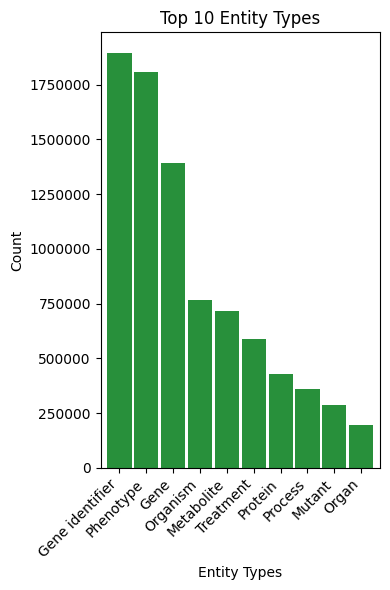

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

combined_types = pd.concat([df['source type resolved'], df['target type resolved']])
# Count the number of occurrences of each unique type
type_counts = combined_types.value_counts()

# Select the top x types
top_types = 10
top_x_types = type_counts.head(top_types)
top_x_types.index = top_x_types.index.str.capitalize()

# Plot the top x types
plt.figure(figsize=(4, 6))
top_x_types.plot(kind='bar', color='#28903B', width=0.9)
plt.title('Top %s Entity Types' % top_types)
plt.xlabel('Entity Types')
plt.ylabel('Count')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Format y-axis
plt.ticklabel_format(style='plain', axis='y')  # Ensure y-axis shows plain numbers
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the plot as a PDF
plt.savefig('figures/fig_3_top_entity_types_updated.pdf', format='pdf')

plt.show()


## What are the top entities per entity type:


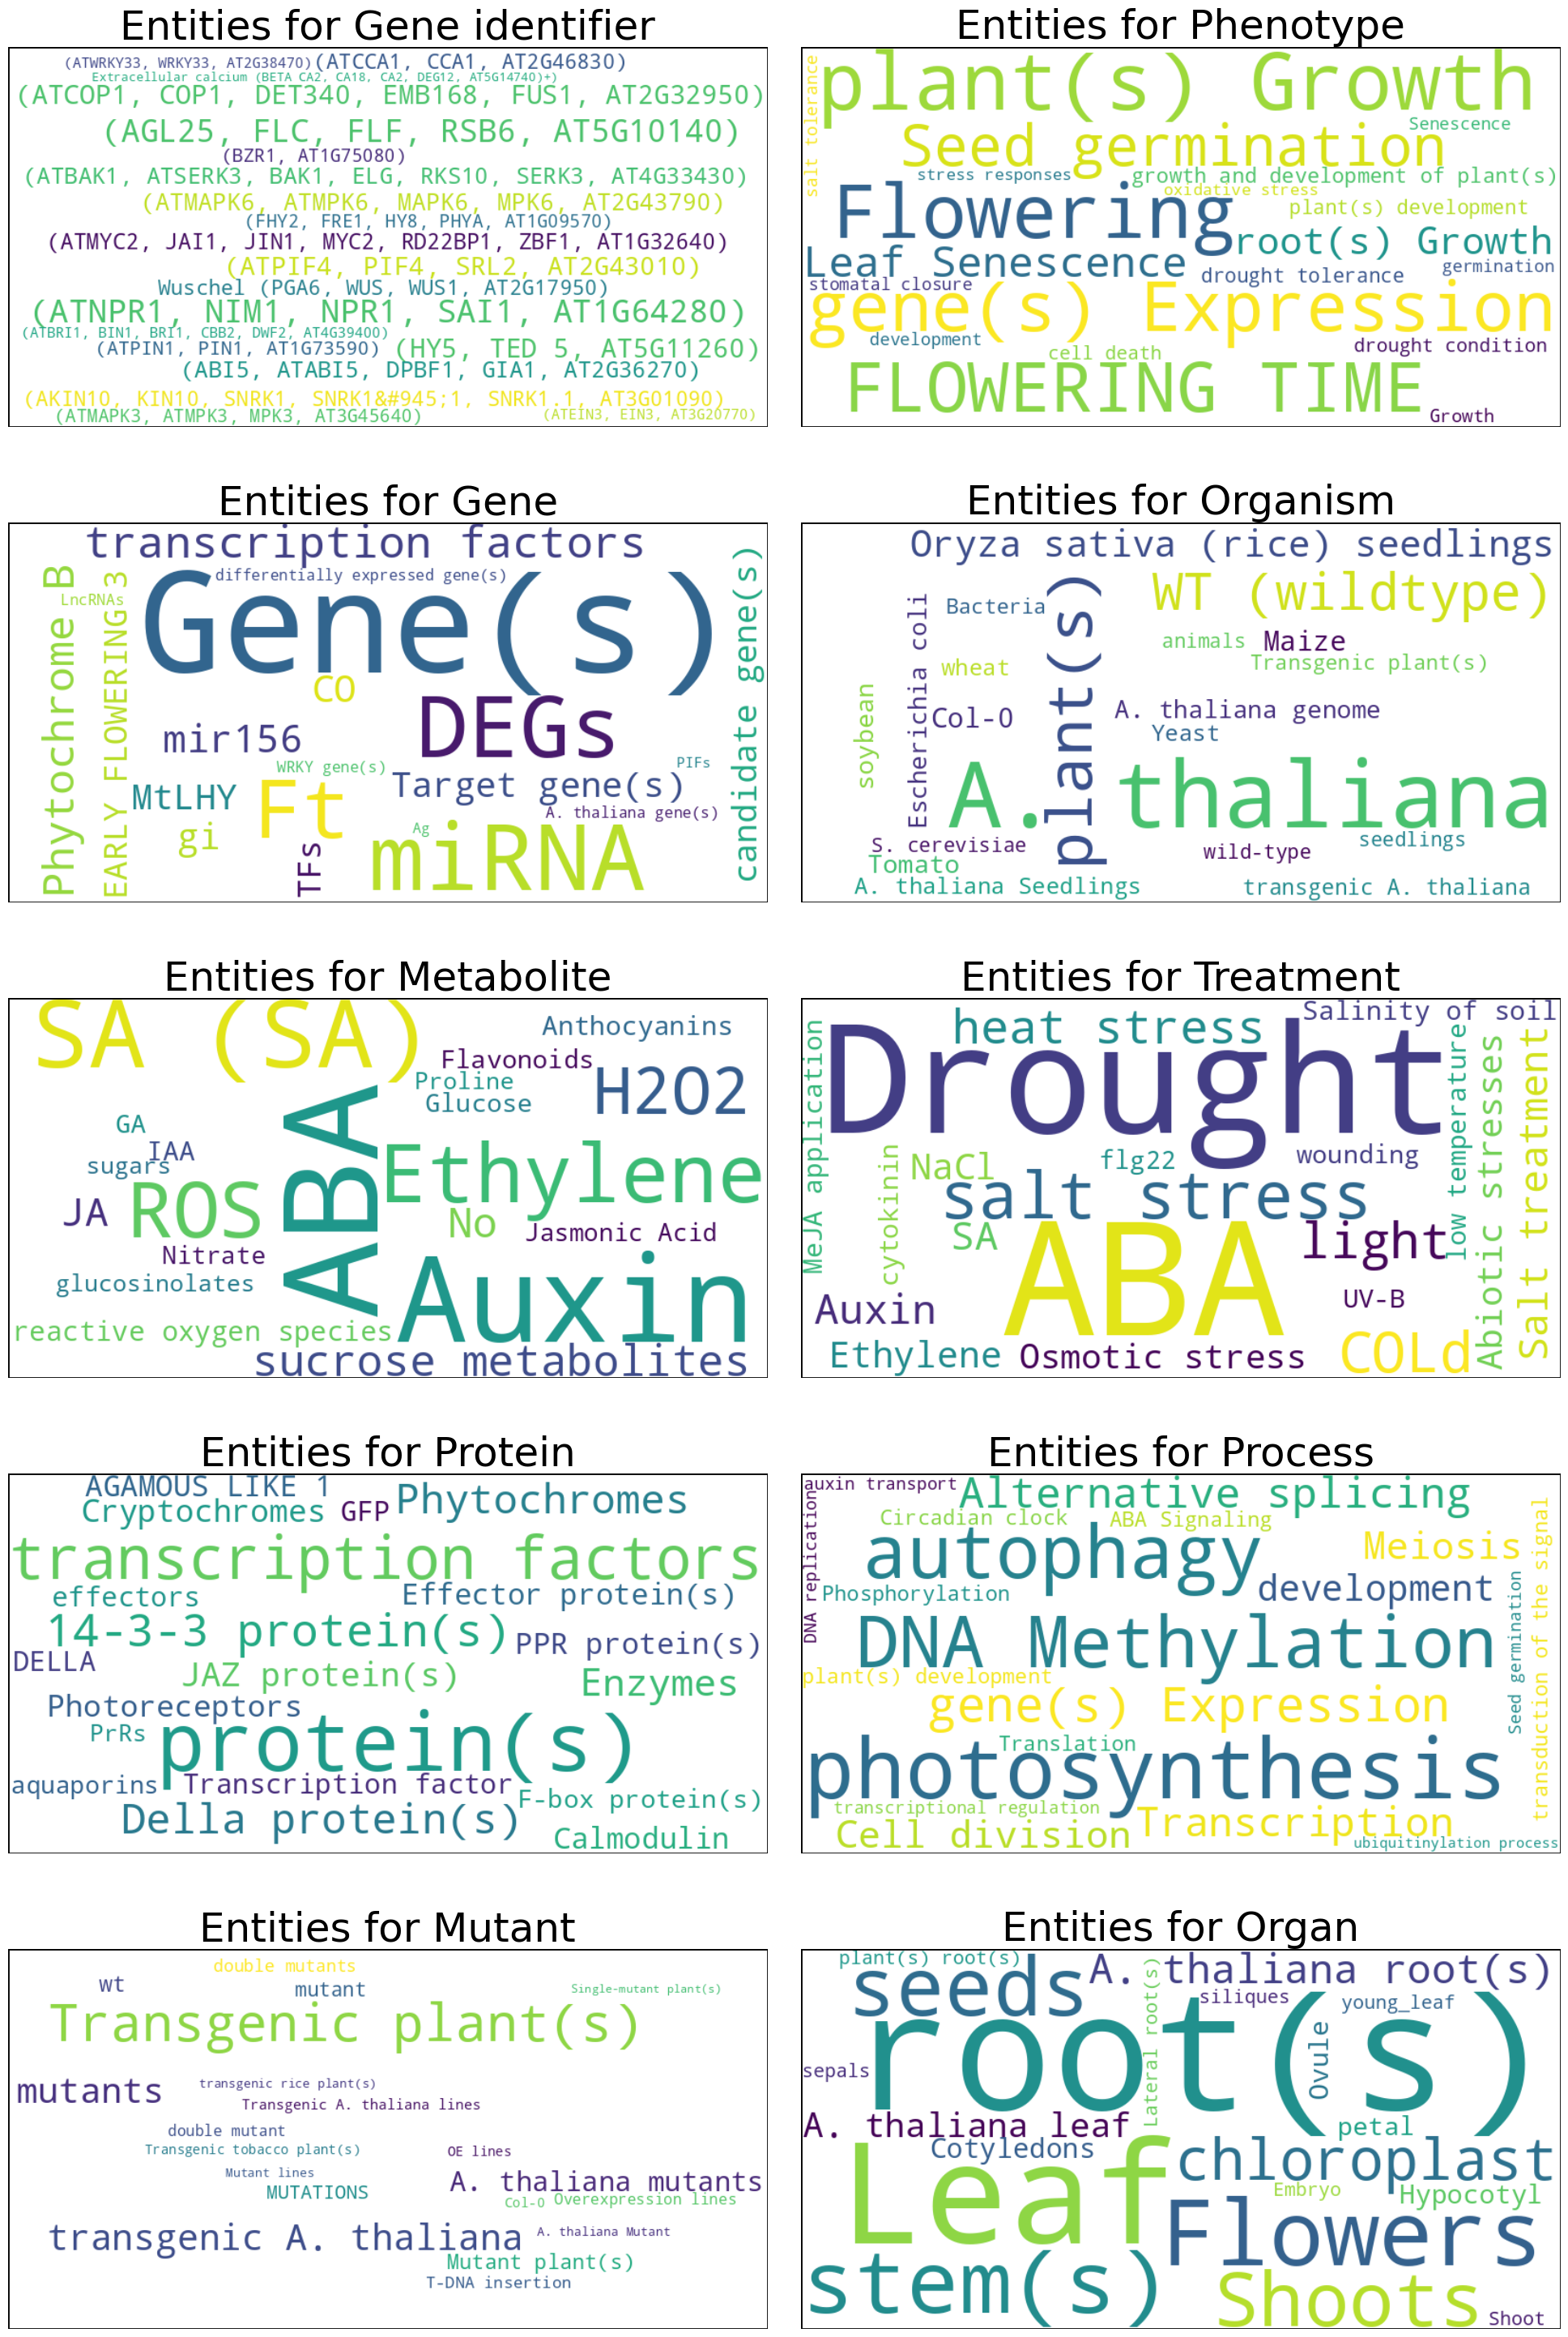

2386727


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as patches

entity_type_threshold = 10  # This can be adjusted to any number
entity_count_threshold = 20

# Assuming 'df' is your DataFrame with columns: source, source_type, target, target_type
# Combine source and target data along with their types
source_data = df[['source resolved', 'source type resolved']]
target_data = df[['target resolved', 'target type resolved']]

source_data.columns = ['entity', 'entity_type']
target_data.columns = ['entity', 'entity_type']

combined_data = pd.concat([source_data, target_data])

# Count occurrences of each entity type
type_counts = combined_data['entity_type'].value_counts()

# Select the top entity types based on a specified threshold

selected_entity_types = type_counts.head(entity_type_threshold).index

# Set up the figure and axes for a 5x2 grid of plots
fig, axes = plt.subplots(5, 2, figsize=(20, 30))  # Adjust figsize to your preference
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each of the selected entity types and create a word cloud for the top entities
for i, entity_type in enumerate(selected_entity_types):
      # This can also be adjusted
    top_entities = combined_data[combined_data['entity_type'] == entity_type]['entity'].value_counts().head(entity_count_threshold)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_entities)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Entities for {entity_type.capitalize()}', fontsize=36)
    axes[i].axis('off')  # Hide the default axis

    # Add a visible black border to each subplot using a rectangle patch
    rect = patches.Rectangle((0, 0), 1, 1, transform=axes[i].transAxes,
                             color='black', linewidth=2, fill=False)
    axes[i].add_patch(rect)

plt.tight_layout(pad=3)  # Increase padding between plots
plt.savefig('figures/fig_3_big_wordcloud.pdf', format='pdf')
plt.show()

unique_count = pd.concat([df['source resolved'], df['target resolved']]).nunique()

print(unique_count)

## Which species are the edges coming from?


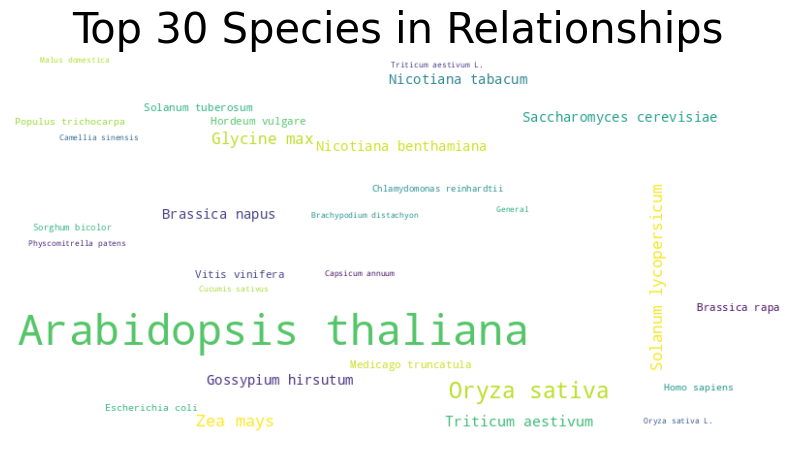

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

species_list = list(df['species'])
species_list_updated = []
for i in species_list:
    if type(i)==str:
        species_list_updated.append(i)

# Step 1: Count the Frequency of Each Relationship Type
relationship_counts = df['species'].value_counts()

# Define the number of top relationship types to select
num_top_relationships = 30  # You can adjust this number as needed

# Step 2: Select the Top Relationship Types
top_relationships = relationship_counts.head(num_top_relationships).to_dict()

# Step 3: Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_relationships)

# Step 4: Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Top {num_top_relationships} Species in Relationships', fontsize=30)
plt.axis('off')  # Hide the axes
plt.savefig('figures/fig_S5_top_species_in_relationships.pdf', format='pdf')
plt.show()


## That is the topology of the knowledge graph?

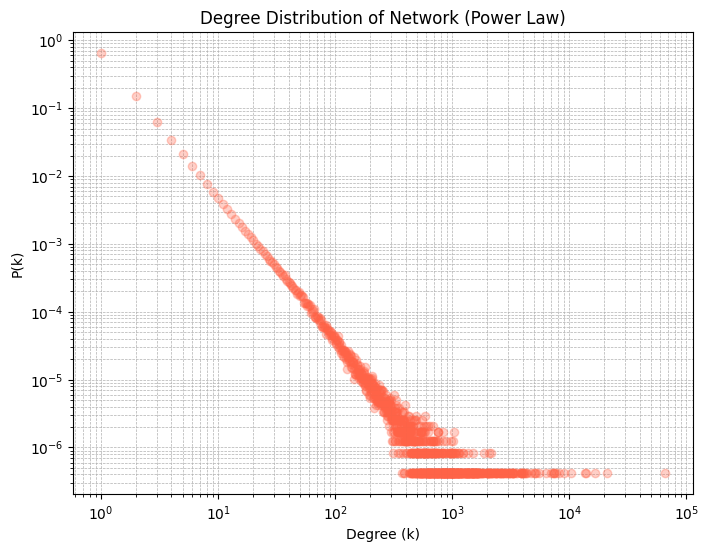

In [56]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame with columns: source, source_type, target, target_type
# The 'source' and 'target' columns represent the relationships between entities.
df = df.dropna(subset=['source resolved', 'target resolved'])
# Step 1: Construct the Network
G = nx.Graph()

# Add edges from DataFrame
edges = list(zip(df['source resolved'], df['target resolved']))
G.add_edges_from(edges)

# Step 2: Calculate the Degree Distribution
degree_sequence = [d for n, d in G.degree()]
degree_count = pd.Series(degree_sequence).value_counts().sort_index()

# Convert to probabilities
degree_count = degree_count / degree_count.sum()

# Step 3: Plot the Power-Law Distribution with Custom Color and Opacity
plt.figure(figsize=(8, 6))

# Custom color and opacity for points
point_color = '#FF6347'  #  color
point_opacity = 0.3  # opacity

plt.loglog(degree_count.index, degree_count.values, marker='o', linestyle='none',
           color=point_color, alpha=point_opacity)

plt.title('Degree Distribution of Network (Power Law)')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig('figures/fig_3_power_law_distribution.pdf', format='pdf')

plt.show()


## How does the knowledge graph change when we remove, 10, 20,..., 90% of articles?

> Add blockquote



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is already defined

# Precompute unique PMIDs once
unique_pmids = df['pubmedID'].unique()
unique_pmids_list = list(unique_pmids)
num_unique_pmids = len(unique_pmids)

# Convert to NumPy arrays for faster operations
pubmedID_array = df['pubmedID'].values
source_array = df['source resolved'].values
target_array = df['target resolved'].values
relationship_array = df['relationship resolved'].values

# Percentages to iterate over (0%, 10%, ..., 90%)
percentages = list(range(0, 99, 10))
num_iterations = 100

# Store results
stats = {}

for percent in percentages:
    print(f"Processing {percent}%")
    stats[percent] = []

    num_to_remove = int(num_unique_pmids * (percent / 100.0))

    for iteration in range(num_iterations):
        # Sample PMIDs to remove
        pmids_to_remove = np.random.choice(unique_pmids_list, num_to_remove, replace=False)
        mask_keep = ~np.isin(pubmedID_array, pmids_to_remove)

        # Apply mask to arrays
        filtered_sources = source_array[mask_keep]
        filtered_targets = target_array[mask_keep]
        filtered_relationships = relationship_array[mask_keep]

        # Collect stats
        num_rows_left = len(filtered_sources)
        unique_entities = pd.Series(np.concatenate((filtered_sources, filtered_targets))).nunique()
        total_relationships = len(filtered_relationships)

        stats[percent].append({
            'iteration': iteration + 1,
            'rows_left': num_rows_left,
            'unique_entities': unique_entities,
            'total_relationships': total_relationships
        })


Processing 0%
Processing 10%
Processing 20%
Processing 30%
Processing 40%
Processing 50%
Processing 60%
Processing 70%
Processing 80%
Processing 90%


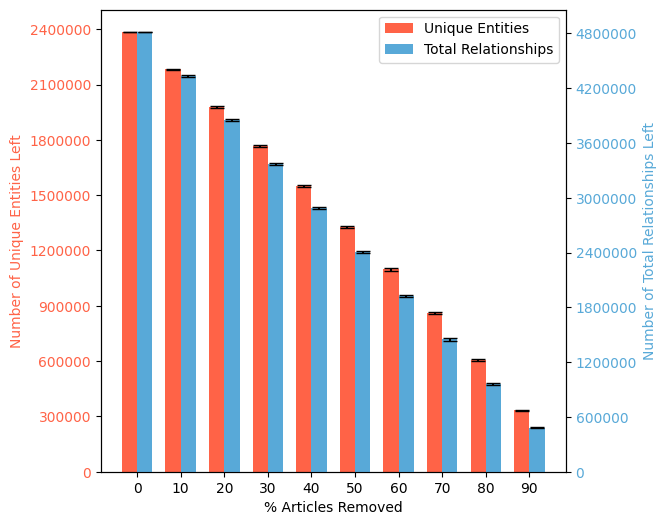

In [50]:
!pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming you already have 'percentages' and 'stats' defined

# Prepare data for unique entities and total relationships
plot_data_entities = []
plot_data_relationships = []

for percent in percentages:
    for stat in stats[percent]:
        plot_data_entities.append({'percent_removed': percent, 'unique_entities': stat['unique_entities']})
        plot_data_relationships.append({'percent_removed': percent, 'total_relationships': stat['total_relationships']})

# Convert to DataFrames for plotting
df_entities = pd.DataFrame(plot_data_entities)
df_relationships = pd.DataFrame(plot_data_relationships)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(6, 6))

# Define width of bars and positions
bar_width = 0.35  # Width of the bars
index = np.arange(len(percentages))  # Position of bars on x-axis

# Compute mean and standard deviation for error bars
entities_means = df_entities.groupby('percent_removed')['unique_entities'].mean()
entities_std = df_entities.groupby('percent_removed')['unique_entities'].std()
relationships_means = df_relationships.groupby('percent_removed')['total_relationships'].mean()
relationships_std = df_relationships.groupby('percent_removed')['total_relationships'].std()

# Plot bar chart for unique entities with error bars on ax1 (left y-axis)
color = '#FF6347'
bars1 = ax1.bar(index, entities_means, bar_width, yerr=entities_std, label='Unique Entities', color=color, capsize=5)

# Set labels for ax1 (left y-axis)
ax1.set_xlabel('% Articles Removed')
ax1.set_ylabel('Number of Unique Entities Left', color=color)

# Turn off scientific notation and set integer ticks on ax1
ax1.ticklabel_format(style='plain', axis='y')
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set the color of the first y-axis labels
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) that shares the same x-axis (percent removed)
ax2 = ax1.twinx()

# Plot bar chart for total relationships with error bars on ax2 (right y-axis)
color = '#58A9D8'
bars2 = ax2.bar(index + bar_width, relationships_means, bar_width, yerr=relationships_std, label='Total Relationships', color=color, capsize=5)

# Set labels for ax2 (right y-axis)
ax2.set_ylabel('Number of Total Relationships Left', color=color)

# Turn off scientific notation and set integer ticks on ax2
ax2.ticklabel_format(style='plain', axis='y')
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set the color of the second y-axis labels
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-ticks to the center of the grouped bars
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(percentages)

# Combine legends for both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('figures/fig_2_articles_removed.pdf', format='pdf')

# Show the plot
plt.show()


## What are the top connected entities?

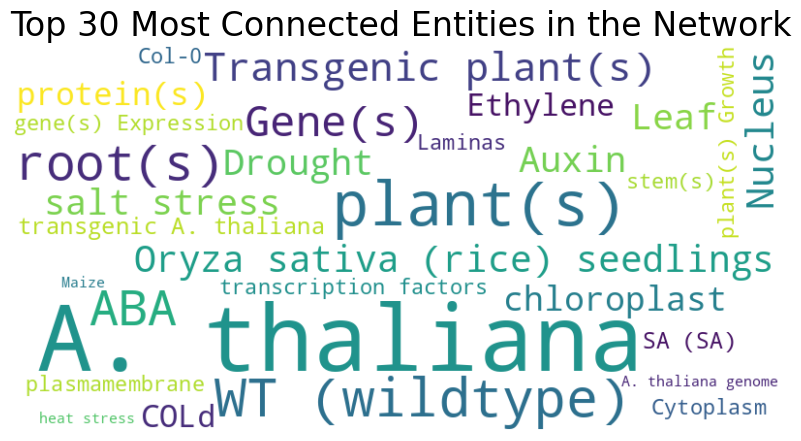

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'df' is your DataFrame with columns: source, source_type, target, target_type
# The 'source' and 'target' columns represent the relationships between entities.
df = df.dropna(subset=['source resolved', 'target resolved'])
# Step 1: Construct the Network
G = nx.Graph()

# Add edges from DataFrame
edges = list(zip(df['source resolved'], df['target resolved']))
G.add_edges_from(edges)

# Step 2: Calculate the Degree of Each Node
degree_dict = dict(G.degree())

# Step 3: Sort Nodes by Degree in Descending Order
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Define the number of top entities to select
num_top_entities = 30  # You can adjust this number as needed

# Step 4: Extract the Most Connected Entities
most_connected_entities = dict(sorted_degree[:num_top_entities])

# Step 5: Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(most_connected_entities)

# Step 6: Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Top {num_top_entities} Most Connected Entities in the Network', fontsize=24)
plt.axis('off')  # Hide the axes
plt.savefig('figures/fig_3_most_connected_entities.pdf', format='pdf')

plt.show()


## What are the top relationships?

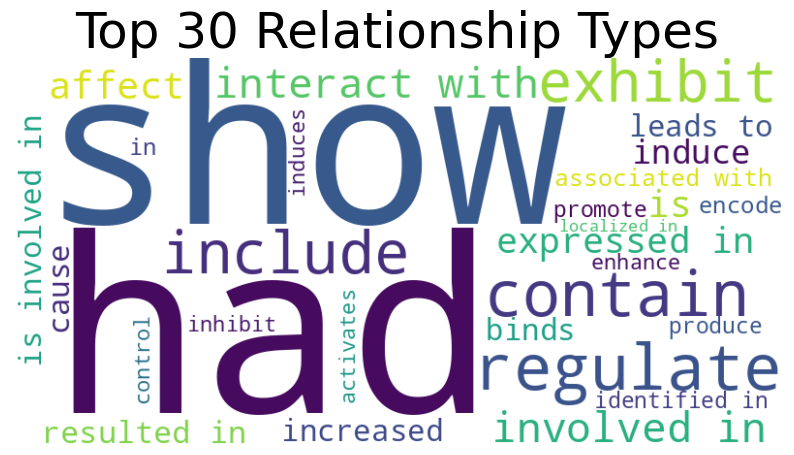

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'df' is your DataFrame with a column 'relationship' representing relationship types

# Step 1: Count the Frequency of Each Relationship Type
relationship_counts = df['relationship resolved'].value_counts()

# Define the number of top relationship types to select
num_top_relationships = 30  # You can adjust this number as needed

# Step 2: Select the Top Relationship Types
top_relationships = relationship_counts.head(num_top_relationships).to_dict()

# Step 3: Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_relationships)

# Step 4: Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Top {num_top_relationships} Relationship Types', fontsize=36)
plt.axis('off')  # Hide the axes
plt.savefig('figures/fig_3_top_30_relationships.pdf', format='pdf')
plt.show()


## How many times are top 10 entities connected?

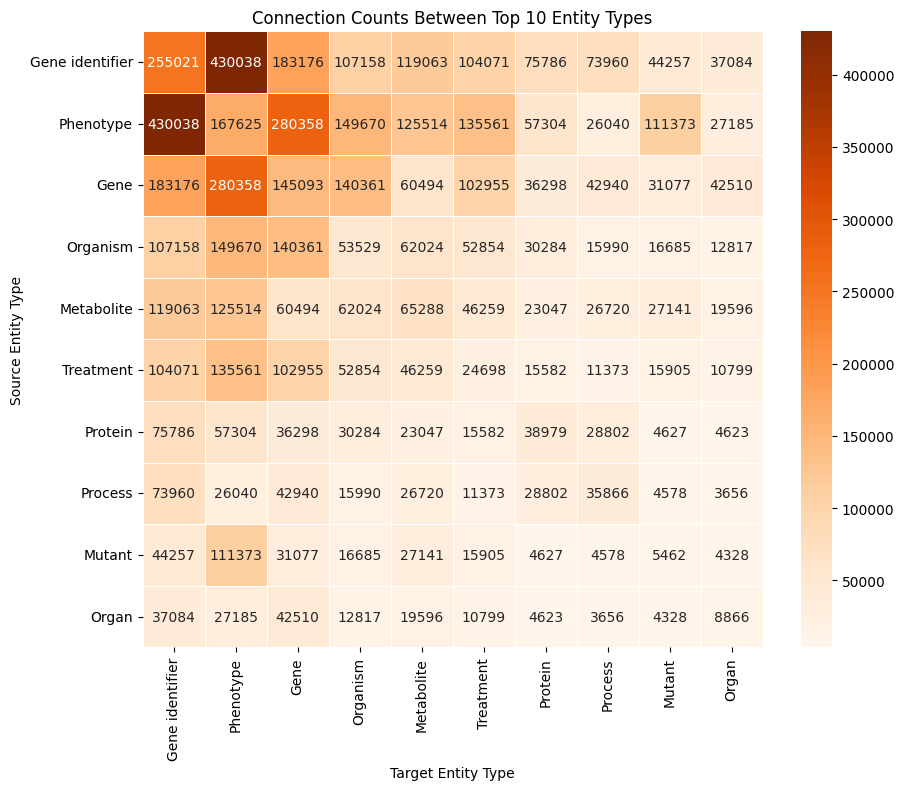

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming 'df' is your DataFrame with columns: source_type, target_type
# The 'source' and 'target' columns represent the relationships between entities.

# Step 1: Identify the Top 10 Entity Types
entity_type_counts = pd.concat([df['source type resolved'], df['target type resolved']]).value_counts()
top_entity_types = entity_type_counts.head(10).index

# Step 2: Filter DataFrame to Only Include Rows with Top 10 Entity Types
filtered_df = df[(df['source type resolved'].isin(top_entity_types)) & (df['target type resolved'].isin(top_entity_types))]

# Convert rows to tuples of (source_type, target_type), capitalizing the first letter
connections = [(row['source type resolved'].capitalize(), row['target type resolved'].capitalize()) for index, row in filtered_df.iterrows()]

# Step 3: Use Counter to count connections
connection_counts = Counter(connections)

# Step 4: Initialize a DataFrame to store connection counts
connection_matrix = pd.DataFrame(0, index=[t.capitalize() for t in top_entity_types], columns=[t.capitalize() for t in top_entity_types])

# Step 5: Populate the DataFrame using the Counter
for (source, target), count in connection_counts.items():
    connection_matrix.loc[source, target] += count
    # If the graph is undirected, also increment the reverse connection
    if source != target:
        connection_matrix.loc[target, source] += count


# Step 6: Generate Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(connection_matrix, annot=True, fmt='d', cmap='Oranges', linewidths=0.5)
plt.title('Connection Counts Between Top 10 Entity Types')
plt.xlabel('Target Entity Type')
plt.ylabel('Source Entity Type')
plt.savefig('figures/fig_3_connection_counts_between_top_10_entity_types.pdf', format='pdf')
plt.show()

## What is the evidence for edges (relationships) that the papers report?

In [26]:

import pandas as pd

#show all pandas columns
pd.set_option('display.max_columns', None)
df = pd.read_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed_gene_identifier.parquet') #read in the knowledge graph file


In [27]:
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.util import ngrams

pubmedid2evidence = {}
pmid, evidence = df['pubmedID'], df['basis']
for i in range(len(pmid)):
    if pmid[i] not in pubmedid2evidence:
        pubmedid2evidence[pmid[i]] = []
    if type(evidence[i])==str:
        pubmedid2evidence[pmid[i]] += [evidence[i].lower()]

#so to not count same evidences from same paper multiple times
for pubmedid in pubmedid2evidence: #convert all unique evidences in a paper into a string
    pubmedid2evidence[pubmedid] = ' '.join(list(set(pubmedid2evidence[pubmedid])))

listOfSentences = []
for pubmedid in pubmedid2evidence: #create a list of strings, where each string is all methods used in a paper
    listOfSentences += [pubmedid2evidence[pubmedid]]


# Creating a bigram set for each sentence separately
bigrams_per_sentence = []

# Tokenize each sentence and generate bigrams for each one individually
for sentence in listOfSentences:
    words_in_sentence = sentence.lower().split()  # Tokenize words
    bigrams_in_sentence = list(ngrams(words_in_sentence, 2))  # Generate bigrams, adjacent two word tuples
    bigrams_per_sentence+=bigrams_in_sentence


bigram_freq = Counter(bigrams_per_sentence)
bigram_freq_top = bigram_freq.most_common(200)
#Used this to shortlist top bigrams
for i in bigram_freq_top:
    print(i)


(('analysis', 'of'), 324295)
(('analysis', 'showing'), 123325)
(('gene', 'expression'), 79613)
(('expression', 'analysis'), 79500)
(('analysis', 'and'), 64129)
(('phenotypic', 'analysis'), 63462)
(('literature', 'review'), 63127)
(('observation', 'of'), 62300)
(('analysis', 'using'), 53689)
(('studies', 'showing'), 52666)
(('genetic', 'analysis'), 49704)
(('studies', 'on'), 43329)
(('in', 'the'), 41517)
(('expression', 'in'), 40980)
(('role', 'in'), 38452)
(('in', 'arabidopsis'), 36011)
(('of', 'the'), 35679)
(('measurement', 'of'), 35578)
(('review', 'on'), 34500)
(('expression', 'of'), 33410)
(('arabidopsis', 'thaliana'), 29101)
(('qrt-pcr', 'analysis'), 27498)
(('literature', 'reference'), 26537)
(('levels', 'in'), 25801)
(('response', 'to'), 25127)
(('and', 'analysis'), 25060)
(('and', 'phenotypic'), 24916)
(('assays', 'showing'), 24770)
(('reference', 'to'), 23884)
(('rna-seq', 'analysis'), 22911)
(('review', 'and'), 22747)
(('in', 'transgenic'), 22589)
(('analysis', 'in'), 22222)

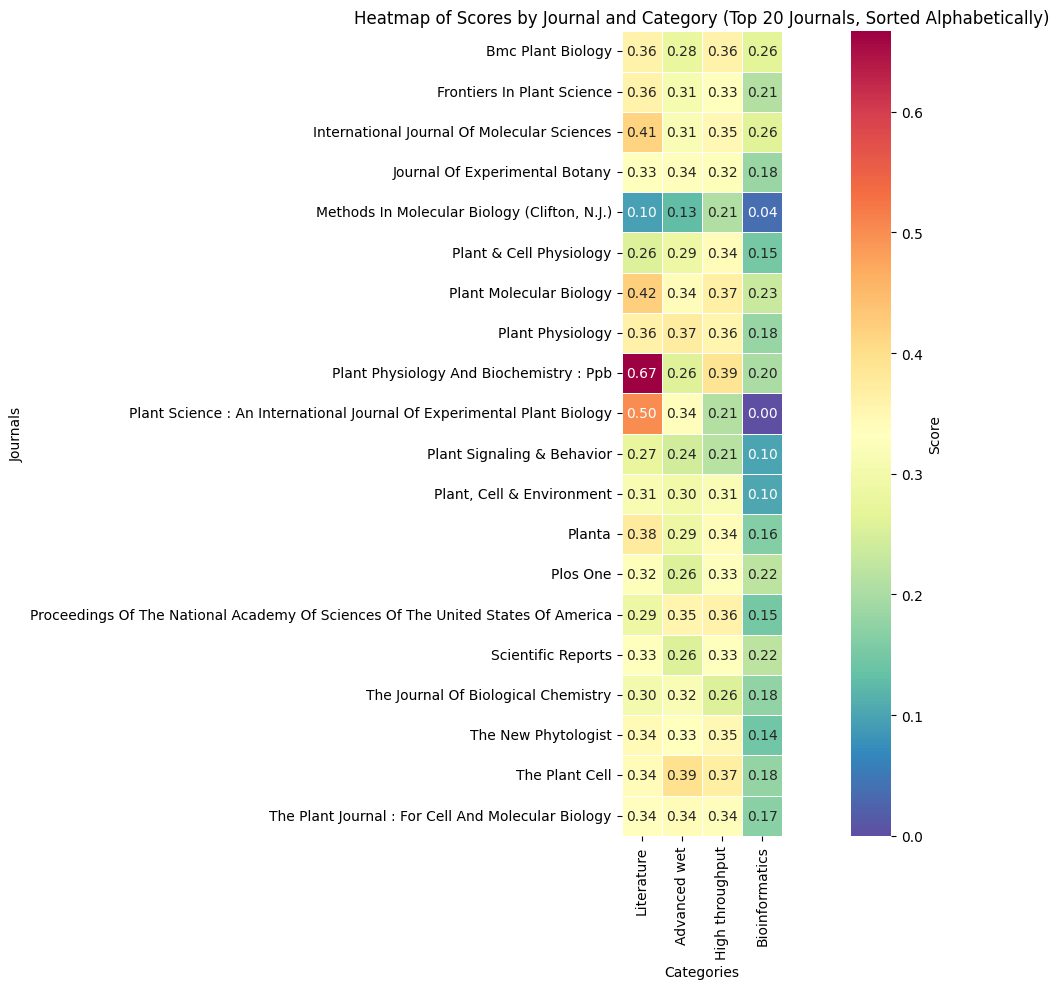

In [53]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#these keywords are manually curated from the output of the above cell

literature = ['literature', 'review']
advanced_wet = ['phenotypic', 'genetic', 'transgenic', 'vivo','vitro','confocal', 'interaction', 'localization', 'quantitative', 'protein', 'activity', 'assay', 'assays', 'yeast', 'subcellular', 'chromatin', 'mutant', 'mutants', 'blot', 'overexpression', 'root', 'enzyme', 'biochemical', 'mass', 'spectrometry', 'precipitation', 'growth', 'microscopy', 'phenotypic']
high_throughput = ['expression', 'microarray', 'sequencing', 'seq','mass', 'transcriptome']
bioinformatics = ['sequence','phylogenetic', 'genomic', 'alignment', 'differential expression']

results = {}

for i in pubmedid2evidence: #checks whether the keywords specified above are in the detected methods string
    scores = [0,0,0,0] #literature, advanced_wet, high_throughput, bioinformatics
    for j in literature:
        if j in pubmedid2evidence[i]:
            scores[0] += 1
    for j in advanced_wet:
        if j in pubmedid2evidence[i]:
            scores[1] += 1
    for j in high_throughput:
        if j in pubmedid2evidence[i]:
            scores[2] += 1
    for j in bioinformatics:
        if j in pubmedid2evidence[i]:
            scores[3] += 1
    results[str(i)] = [scores[0]/len(literature), scores[1]/len(advanced_wet), scores[2]/len(high_throughput), scores[3]/len(bioinformatics)] #normalizing by keyword list lengths


#getting journal names
pubmedid2journal = {}
journal2count = {}
for i in open("annotation/analyzed_papers.txt",'r').readlines()[1:]: #download from Marek drive and add to KG colab directory
    splitta = i.split('\t')
    if splitta[-1]=='yes\n': #only grabbing open acceess
        pubmedid2journal[splitta[-2]] = splitta[0]

    if splitta[0].title() not in journal2count:
        journal2count[splitta[0].title()] = 0
    journal2count[splitta[0].title()] += 1

#making dataframe
journals, lit, adv, high, bioinfo = [],[],[],[],[]
for i in results:
    if i in pubmedid2journal: #only grabbing open acceess
        journals += [pubmedid2journal[i].title()]
        lit += [results[i][0]]
        adv += [results[i][1]]
        high += [results[i][2]]
        bioinfo += [results[i][3]]


df_evidences = pd.DataFrame({'Journal': journals, 'Literature': lit, 'Advanced wet': adv, 'High throughput': high, 'Bioinformatics': bioinfo})

# Sorting the dictionary by number of articles in descending order and selecting the top 20
sorted_journals = sorted(journal2count.items(), key=lambda item: item[1], reverse=True)
top_20_journals = [journal[0] for journal in sorted_journals[:20]]

# Filtering the DataFrame to include only top 20 journals based on journal2count
top_journals_df = df_evidences[df_evidences['Journal'].isin(top_20_journals)]

# Aggregating scores per journal to ensure each journal appears once
agg_df = top_journals_df.groupby('Journal').mean()

# Sorting the DataFrame alphabetically by the index (Journal names)
agg_df.sort_index(inplace=True)

# Keeping only the category columns
agg_df = agg_df[['Literature', 'Advanced wet', 'High throughput', 'Bioinformatics']]

# Create the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(agg_df, cmap='Spectral_r', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Score'}, square=True)

# Rotate x-ticks 45 degrees for better readability and adjust the alignment

# Add labels and title
plt.title("Heatmap of Scores by Journal and Category (Top 20 Journals, Sorted Alphabetically)")
plt.xlabel("Categories")
plt.ylabel("Journals")

# Show the heatmap
plt.tight_layout()

plt.savefig('figures/fig_2_heatmap_of_scores_by_journal_and_category.pdf', format='pdf')

plt.show()

# Literature analysis

## Metainfo of the analyzed articles

In [ ]:
import matplotlib.pyplot as plt
from Bio import Entrez

Entrez.email = "mutwil@gmail.com"
source_counts = df['p_source'].values

abs, other = [],[]
other_type = []
all_pubmed = []
for i in source_counts:
    splitta = i.split('_')
    all_pubmed.append(splitta[0])
    if 'abstract' in i:
        abs.append(splitta[0])
    else:
        other.append(splitta[0])
        other_type.append(splitta[1])

only_abs = list(set(all_pubmed)-set(other))
full = list(set(all_pubmed)-set(only_abs))

pmid2journal = {}

# Define a function to chunk a list into sublists of a specified size
def chunk_list(input_list, chunk_size):
    """Splits input_list into chunks of size chunk_size."""
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]

# Chunk size for PubMed requests
chunk_size = 9000
all_pmids = full+only_abs

# Process each chunk. Takes a long time

save = ['Journal\tTitle\tYear\tPubmedID\tFull text (yes/no)\n']

for chunk in chunk_list(all_pmids, chunk_size):
    id_list = ','.join(chunk)
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    records = Entrez.read(handle)

    for record in records['PubmedArticle']:

        pmid = record['PubmedData']['ArticleIdList'][0]
        try:
            year = record['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year']
        except:
            year = '-'
        journal = record['MedlineCitation']['Article']['Journal']['Title']
        title = record['MedlineCitation']['Article']['ArticleTitle']
        if str(pmid) in full:
            save.append(journal+'\t'+title+'\t'+year+'\t'+pmid+'\t'+'yes\n')
        else:
            save.append(journal+'\t'+title+'\t'+year+'\t'+pmid+'\t'+'no\n')


v = open('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/analyzed_papers.txt','w')
v.writelines(save)
v.close()


##How many open and close access papers are there?

In [ ]:
!pip install biopython
import matplotlib.pyplot as plt
from Bio import Entrez

Entrez.email = "mutwil@gmail.com"
source_counts = df['p_source'].values

abs, other = [],[]
other_type = []
all_pubmed = []
for i in source_counts:
    splitta = i.split('_')
    all_pubmed.append(splitta[0])
    if 'abstract' in i:
        abs.append(splitta[0])
    else:
        other.append(splitta[0])
        other_type.append(splitta[1])


print(set(other_type))

only_abs = list(set(all_pubmed)-set(other))
full_test = list(set(all_pubmed)-set(only_abs))

print(len(only_abs))
print(len(full_test))

pmid2journal = {}

# Define a function to chunk a list into sublists of a specified size
def chunk_list(input_list, chunk_size):
    """Splits input_list into chunks of size chunk_size."""
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]

# Chunk size for PubMed requests
chunk_size = 9000
all_pmids = only_abs + full_test

# Process each chunk. Takes a long time
for chunk in chunk_list(all_pmids, chunk_size):
    id_list = ','.join(chunk)
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    records = Entrez.read(handle)

    for record in records['PubmedArticle']:
        pmid = record['PubmedData']['ArticleIdList'][0]
        pmid2journal[pmid] = record['MedlineCitation']['Article']['Journal']['Title']

# The pmid2journal dictionary now contains the journal titles for all processed PubMed IDs
print(f"Total number of journals retrieved: {len(pmid2journal)}")

#save the json
import json
with open('annotation/pmid2journal.json', 'w') as f:
    json.dump(pmid2journal, f)

In [30]:
import json

with open('annotation/pmid2journal.json', 'r') as f:
    pmid2journal = json.load(f)

journal2type = {}

for i in pmid2journal:
    if pmid2journal[i] not in journal2type:
        journal2type[pmid2journal[i]] = [0,0] #[open, not open]

    if i in full_test:
        journal2type[pmid2journal[i]][0] += 1
    else:
        journal2type[pmid2journal[i]][1] += 1

how_many_journals = 20

# Convert dictionary to DataFrame
df_journal2type = pd.DataFrame.from_dict(journal2type, orient='index', columns=['Open Access', 'Closed Access'])

# Reset index to add 'Journal' as a column
df_journal2type = df_journal2type.reset_index()
df_journal2type.rename(columns={'index': 'Journal'}, inplace=True)

# Remove rows with NaN journal names
df_journal2type.dropna(subset=['Journal'], inplace=True)

# Calculate total articles
df_journal2type['Total'] = df_journal2type['Open Access'] + df_journal2type['Closed Access']

# Sort by total number of articles
df_journal2type = df_journal2type.sort_values(by='Total', ascending=False)

# Select top x journals
top_journals = df_journal2type.head(how_many_journals)


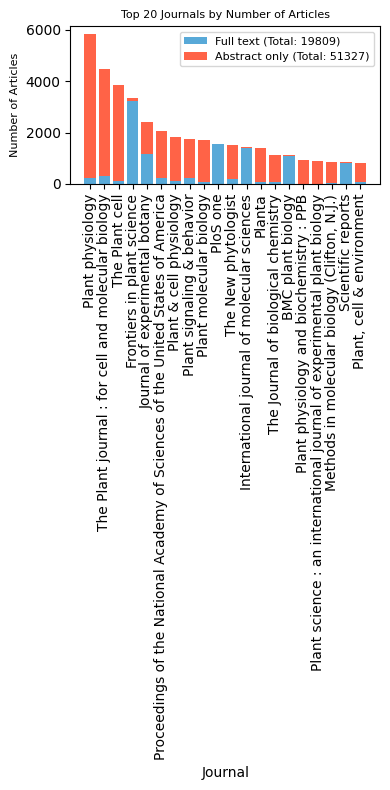

In [ ]:
# Plot the stacked bar chart
plt.figure(figsize=(4, 8))
plt.bar(top_journals['Journal'], top_journals['Open Access'], color='#58A9D8', label='Full text (Total: %s)' % len(full_test))
plt.bar(top_journals['Journal'], top_journals['Closed Access'], bottom=top_journals['Open Access'], color='#FF6347', label='Abstract only (Total: %s)' % len(only_abs))

plt.title('Top %s Journals by Number of Articles' % how_many_journals, fontsize=8)
plt.xlabel('Journal')
plt.ylabel('Number of Articles', fontsize=8)
plt.xticks(rotation=90, fontsize=10)
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig('figures/fig_1_top_20_journals.pdf', format='pdf')
plt.show()

## How many entities per categoryt (abs, intro, res)
Preparing data for the below

In [32]:
import re

# Calculate the number of rows, unique entities, and unique entity types per each p_source considering both source and target
# Convert DataFrame to a list of lists
list_of_lists = df.values.tolist()



pmid2typas2entities = {}
pmid2edges = {}
for i in list_of_lists:
    if i[6] not in pmid2typas2entities: #if pmid not in
        pmid2typas2entities[i[6]] = {}
        pmid2edges[i[6]] = {}


    source = re.sub(r'\d+', '', i[7].split('_')[1]) #strip so that you only have 'abstract', 'results'
    if source not in pmid2typas2entities[i[6]]:
        pmid2typas2entities[i[6]][source] = []
        pmid2edges[i[6]][source] = []
    pmid2typas2entities[i[6]][source] +=[i[16], i[17]] #add both source and target entities to the source
    pmid2edges[i[6]][source] +=[i[18]] #add edge to the source

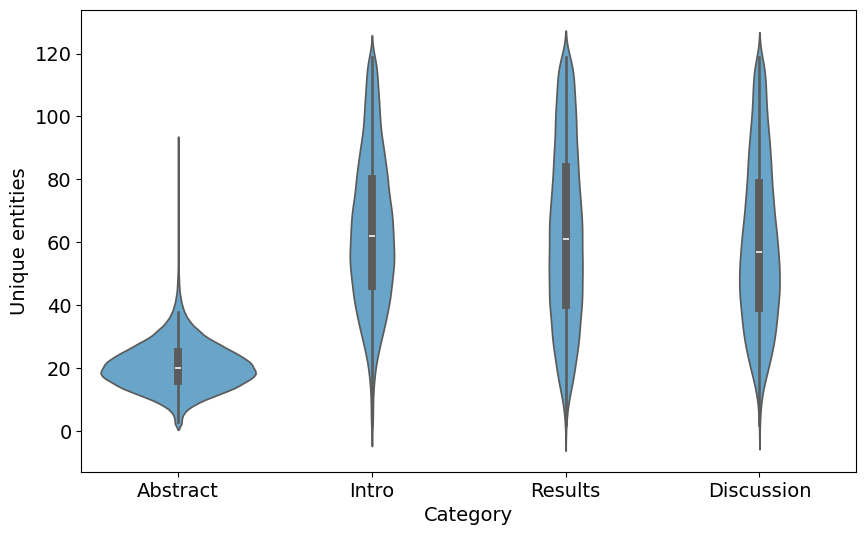

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

typas_to_count_entities = {}
for i in pmid2typas2entities:
    for j in pmid2typas2entities[i]:
        if j not in typas_to_count_entities:
            typas_to_count_entities[j] = []
        typas_to_count_entities[j]+=[len(set(pmid2typas2entities[i][j]))]



# Convert the dictionary to a DataFrame

df_count_entities = pd.DataFrame([(k.capitalize(), v) for k, vals in typas_to_count_entities.items() for v in vals], columns=['Category', 'Unique entities'])
df_count_entities['Category'] = df_count_entities['Category'].replace('Discuss', 'Discussion')

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_count_entities['Unique entities'].quantile(0.25)
Q3 = df_count_entities['Unique entities'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df_count_entities[(df_count_entities['Unique entities'] >= lower_bound) & (df_count_entities['Unique entities'] <= upper_bound)]

# Create a swarm plot
plt.figure(figsize=(10, 6))
#with increased font sized
sns.violinplot(x='Category', y='Unique entities', data=filtered_df, color='#58A9D8')

# Axis labels
plt.xlabel('Category', fontsize=14)
plt.ylabel('Unique entities', fontsize=14)

# Tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)




plt.savefig('figures/fig_2_top_entities_per_type_updated.pdf', format='pdf')

# Display the plot
plt.show()

## How many relationships per category (abs, intro, res)

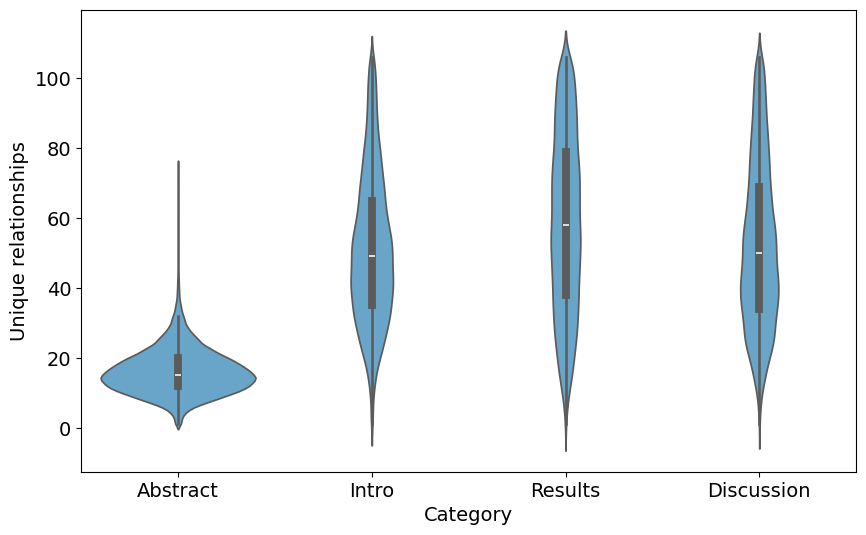

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

typas_to_count = {}
for i in pmid2edges:
    for j in pmid2edges[i]:
        if j not in typas_to_count:
            typas_to_count[j] = []
        typas_to_count[j]+=[len(pmid2edges[i][j])]



# Convert the dictionary to a DataFrame

df_count = pd.DataFrame([(k.capitalize(), v) for k, vals in typas_to_count.items() for v in vals], columns=['Category', 'Relationships'])
df_count['Category'] = df_count['Category'].replace('Discuss', 'Discussion')

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_count['Relationships'].quantile(0.25)
Q3 = df_count['Relationships'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df_count[(df_count['Relationships'] >= lower_bound) & (df_count['Relationships'] <= upper_bound)]

# Create a swarm plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Relationships', data=filtered_df, color='#58A9D8')

# Axis labels
plt.xlabel('Category', fontsize=14)
plt.ylabel('Unique relationships', fontsize=14)

# Tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.savefig('figures/fig_2_top_relationships_per_type_updated.pdf', format='pdf')

# Display the plot
plt.show()

# Journal keyword and tSNE analysis of papers

Getting the abstracts. Can be disabled after the run

In [ ]:

from Bio import Entrez
import csv
import time

# Provide your email to NCBI
Entrez.email = "mutwil@gmail.com"

# List of PubMed IDs (example, replace with your list)

pubmed_ids = list(set(df.pmid))


# Define the chunk size
chunk_size = 9000

def fetch_abstracts(pubmed_ids_chunk):
    """Fetch abstracts for a chunk of PubMed IDs."""
    try:
        handle = Entrez.efetch(db="pubmed", id=pubmed_ids_chunk, rettype="abstract", retmode="text")
        abstracts = handle.read().split("\n\n\n")  # Split by double newline for each abstract
        handle.close()
        return abstracts
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Define the output file name
output_file = "annotation/pubmed_abstracts.txt"

# Save abstracts to a CSV file
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["PubMedID", "Abstract"])  # Write header

    # Fetch abstracts in chunks
    for i in range(0, len(pubmed_ids), chunk_size):
        chunk = pubmed_ids[i:i + chunk_size]
        abstracts = fetch_abstracts(chunk)

        for j, abstract in enumerate(abstracts):
            writer.writerow([str(chunk[j])+'\t'+abstract.strip().replace('\n','')])  # Write PubMed ID and abstract

        print(f"Processed chunk {i // chunk_size + 1}/{(len(pubmed_ids) + chunk_size - 1) // chunk_size}")

        # Optional: pause to respect NCBI usage policies (to avoid overloading their servers)
        time.sleep(1)

print(f"Abstracts saved to {output_file}")


In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')

print('keyword2organ')
###read in abstracts and find matching keywords
stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()
pmid2abst = {}

#moved this out as it takes ages to run
for i in open("annotation/pubmed_abstracts.txt",'r').readlines()[1:]: #can select x abstracts here
    splitta = i.split('\t')
    words = word_tokenize(splitta[1])
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    pmid2abst[splitta[0]] = lemmatized_words


#getting list of organs, biological processes and cellular components
organ2keyword = {}
keyword2organ = {}
for i in open('annotation/organs_keywords.txt','r').readlines():
    splitta = i.split(':')
    if splitta!=['\n']:
        organ2keyword[splitta[0]] = [word.strip() for word in splitta[1].split(',')]
        for worda in [word.strip() for word in splitta[1].split(',')]:
            if worda.lower() not in keyword2organ:
                keyword2organ[worda.lower()] = [splitta[0]]
            else:
                keyword2organ[worda.lower()] += [splitta[0]]

print('pmid2abst')
category_words = []
lemmatizer = WordNetLemmatizer()
for words in keyword2organ:
    #stemmed_words = stemmer.stem(words)
    lemmatized_words = lemmatizer.lemmatize(words)
    category_words+=[lemmatized_words]

category_words= list(set(category_words))
print('category')

pmid2abst
category


## Number of articles per category

<Figure size 800x4000 with 0 Axes>

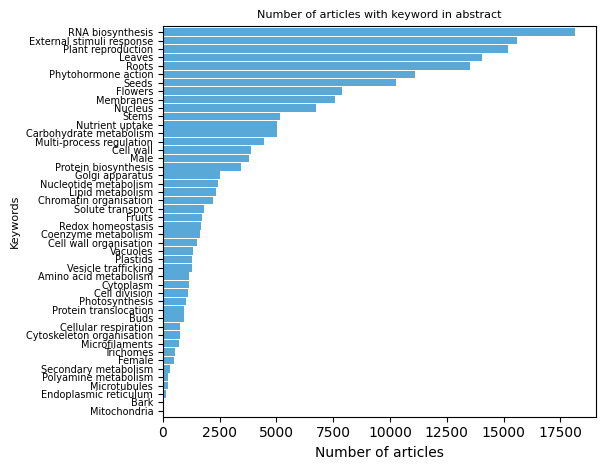

In [ ]:
import matplotlib.pyplot as plt

typa2count = {}
for abst in pmid2abst:
    for typa in organ2keyword:
        if len(set(pmid2abst[abst])&set(organ2keyword[typa]))>0:
            if typa not in typa2count:
                typa2count[typa] = 0
            typa2count[typa] += 1

nr_to_plot = 30
df_typa2count = pd.DataFrame.from_dict(typa2count, orient='index', columns=['Number of articles with keyword in abstract'])

# Sort the DataFrame by the count column in descending order
df_typa2count_sorted = df_typa2count.sort_values(by='Number of articles with keyword in abstract', ascending=True)  # Replace 'count_column_name' with the actual name of the count column

# Plot the bar chart horizontally after sorting
plt.figure(figsize=(8, 40))  # Increase the figure height to 40 for better spacing
df_typa2count_sorted.plot(kind='barh', color='#58A9D8', width=0.9, legend=False)  # Use 'barh' for a horizontal bar chart

plt.title('Number of articles with keyword in abstract', fontsize=8)
plt.xlabel('Number of articles')
plt.ylabel('Keywords', fontsize=8)
plt.yticks(fontsize=7)  # Reduce font size for better readability
plt.xticks(fontsize=10)

plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Adjust subplot to provide more space for y-axis labels
plt.savefig('figures/top_entities_per_type_updated.pdf', format='pdf')
plt.show()

## Which keywords tend to co-occur?

In [ ]:
#making matrix, where rows are articles, and columns are keywords. Only include articles that have at least one keyword
from itertools import combinations

keywords = []
pubmed2keywords = {}

for abst in pmid2abst:
    keywords+=[set(pmid2abst[abst])&set(category_words)]
    pubmed2keywords[abst] = [set(pmid2abst[abst])&set(category_words)]

# Initialize a co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=category_words, columns=category_words)

# Populate the co-occurrence matrix
for keyword_set in keywords:
    for keyword1, keyword2 in combinations(keyword_set, 2):
        co_occurrence_matrix.loc[keyword1, keyword2] += 1
        co_occurrence_matrix.loc[keyword2, keyword1] += 1  # Ensure the matrix is symmetric

# Display the co-occurrence matrix
# Flatten the matrix to a list of tuples (keyword1, keyword2, count)
co_occurrences = []
for i in range(len(co_occurrence_matrix)):
    for j in range(i+1, len(co_occurrence_matrix)):
        keyword1 = co_occurrence_matrix.index[i]
        keyword2 = co_occurrence_matrix.columns[j]
        count = co_occurrence_matrix.iloc[i, j]
        if count > 0:  # Only consider pairs with at least one co-occurrence
            co_occurrences.append((keyword1, keyword2, count))

# Convert to DataFrame and sort by the count in descending order
co_occurrences_df = pd.DataFrame(co_occurrences, columns=['Keyword1', 'Keyword2', 'Count'])
co_occurrences_df_sorted = co_occurrences_df.sort_values(by='Count', ascending=False)

# Save the sorted co-occurrences to a CSV file
output_file = 'annotation/sorted_co_occurrences.tsv'
co_occurrences_df_sorted.to_csv(output_file, sep='\t', index=False)

#then visualize in cytoscape

In [ ]:
#Saving the pubmed2keywords as dataframe
save = []
for i in pubmed2keywords:
    save.append(i.replace('"','')+'\t'+'\t'.join(list(pubmed2keywords[i][0]))+'\n')

v = open('annotation/abstract2keyword.txt','w')
v.writelines(save)
v.close()

## Typical keywords per journal

In [ ]:
import collections
a = open('annotation/pubmed_abstracts.txt','r').read().replace('"','').splitlines()[1:]

pubmed2journal = {}
journal2pubmed = {}
for i in a:
    splitta = i.split('\t')
    try:
        pubmed, journal = splitta[0], splitta[1].split('.')[1].lstrip().rstrip()
        pubmed2journal[pubmed] = journal
        if journal not in journal2pubmed:
            journal2pubmed[journal] = []
        journal2pubmed[journal] += [pubmed]
    except:
        pass

updated_pubmed2keywords = {}
for journal in pubmed2keywords:
    updated_pubmed2keywords[journal.replace('"','')] = pubmed2keywords[journal]

journal2pubmed2keywords = {}
for journal in journal2pubmed:
    keywords = []

    for pubmed in journal2pubmed[journal]:
        if pubmed in pubmed2keywords:
            keywords += list(updated_pubmed2keywords[pubmed])

    journal2pubmed2keywords[journal] = keywords

for journal in journal2pubmed2keywords:
    print(journal2pubmed2keywords[journal])

[set(), set(), set(), set(), set(), set(), set(), {'kinetochore', 'centromere'}, set(), {'transcription'}, set(), set(), set(), set(), {'germination', 'seed', 'transcription'}, set(), set()]
[]
[]
[]
[]
[set()]
[set(), set(), {'root'}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'tonoplast'}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[set()]
[]
[set()]
[]
[]
[]
[]
[]
[]
[]
[]
[set()]
[]
[]
[]
[]
[]
[set()]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[set()]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[set()]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'root'}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

## tSNE analysis

In [ ]:
##@title Run this before tsne

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

print('keyword2organ')
###read in abstracts and find matching keywords
stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()
pmid2abst = {}

#moved this out as it takes ages to run
for i in open("annotation/pubmed_abstracts.txt",'r').readlines()[1:]: #can select x abstracts here
    splitta = i.split('\t')
    words = word_tokenize(splitta[1])
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    pmid2abst[splitta[0]] = lemmatized_words


#getting list of organs, biological processes and cellular components
organ2keyword = {}
keyword2organ = {}
for i in open('annotation/organs_keywords.txt','r').readlines():
    splitta = i.split(':')
    if splitta!=['\n']:
        organ2keyword[splitta[0]] = [word.strip() for word in splitta[1].split(',')]
        for worda in [word.strip() for word in splitta[1].split(',')]:
            if worda.lower() not in keyword2organ:
                keyword2organ[worda.lower()] = [splitta[0]]
            else:
                keyword2organ[worda.lower()] += [splitta[0]]

print('pmid2abst')
category_words = []
lemmatizer = WordNetLemmatizer()
for words in keyword2organ:
    #stemmed_words = stemmer.stem(words)
    lemmatized_words = lemmatizer.lemmatize(words)
    category_words+=[lemmatized_words]

category_words= list(set(category_words))
print('category')

#making matrix, where rows are articles, and columns are keywords. Only include articles that have at least one keyword
matrix = []
non_zeros = []
pmids = sorted(pmid2abst.keys())
for abst in pmids:
    temp =[]
    for word in category_words:
            if word in pmid2abst[abst]:
                temp.append(1)
            else:
                temp.append(0)
    if sum(temp)>0:
        matrix.append(temp)
        non_zeros.append(abst)
print('matrix')

df = pd.DataFrame(matrix, columns=category_words, index=non_zeros)
df.to_csv('annotation/pubmed2keyword.txt', sep='\t', index=False)

keyword2organ
pmid2abst
category
matrix


In [ ]:
import os
import json
import time
import pickle
import pandas as pd
from sklearn.cluster import KMeans
import collections
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import math
path = ''


import imageio



#tSNE madness
perp = [50, 20, 5] #[100, 70, 40, 30, 50, 5, 10, 20, 70, 100] #
learning_r = [10, 100, 500, 800, 1000]
learning_r.reverse()

df = pd.DataFrame(matrix, columns=category_words, index=non_zeros)

for perplexity in perp:
    for learning_rate in learning_r:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='random', learning_rate=learning_rate, n_jobs=80)
        vis_dims = tsne.fit_transform(df)

        with open('figures/tsne_manualCategories_%s_%s.pkl' % (perplexity, learning_rate), 'wb') as f:
            pickle.dump(vis_dims, f)

        # Create the figure and the grid of subplots
        x = [x for x, y in vis_dims]
        y = [y for x, y in vis_dims]

        # Plot the scatterplot in the current subplot
        plt.scatter(x, y, cmap='viridis', alpha=0.01, marker='.')
        # Save the figure
        plt.tight_layout()
        plt.savefig('figures/tsne_manual_categories_%s_%s.png' % (perplexity, learning_rate), dpi=600)

        # Clear the figure
        plt.clf()

print('tsne ')
perp = [40]
learning_r = [1000]
# Create the figure and the grid of subplots

with open('figures/tsne_manualCategories_%s_%s.pkl' % (perp[0], learning_r[0]), 'rb') as f:
    vis_dims = pickle.load(f)
df_tsne = pd.DataFrame(vis_dims, columns=['Dimension_1', 'Dimension_2'])


column_names = df.columns.tolist()
class2column = {}
for i in column_names: #i = column names in matrix used to make tsne
    for j in keyword2organ:
        if i in j:
            keywords = keyword2organ[j]
            for keyz in keywords:
                if keyz not in class2column:
                    class2column[keyz] = [i]
                else:
                    class2column[keyz] += [i]


classa2nonzeros = {}
for classa in class2column:
    columns_to_check = class2column[classa]
    selected_rows = df[columns_to_check]
    rows_with_all_zeros = (selected_rows == 0).all(axis=1)
    non_zeros = ~rows_with_all_zeros
    classa2nonzeros[classa] = non_zeros

print('classa2nonzeros')
organz = ['Stems', 'Leaves', 'Roots', 'Flowers', 'Fruits', 'Seeds', 'Trichomes', 'Bark', 'Male', 'Female']
pathways = ['Photosynthesis', 'Cellular respiration', 'Carbohydrate metabolism', 'Amino acid metabolism', 'Lipid metabolism', 'Nucleotide metabolism', 'Coenzyme metabolism', 'Polyamine metabolism', 'Secondary metabolism', 'Redox homeostasis', 'Phytohormone action', 'Chromatin organisation', 'Cell division', 'RNA biosynthesis', 'Protein biosynthesis', 'Cytoskeleton organisation', 'Cell wall organisation', 'Vesicle trafficking', 'Protein translocation', 'Solute transport', 'Nutrient uptake', 'External stimuli response', 'Multi-process regulation', 'Plant reproduction']
compartments = ['Nucleus', 'Cytoplasm', 'Membranes', 'Cell wall', 'Endoplasmic reticulum', 'Golgi apparatus', 'Mitochondria', 'Plastids', 'Vacuoles', 'Peroxisomes', 'Microtubules', 'Microfilaments', 'Plasmodesmata']


allTypes = {'Organs':organz, 'Pathways':pathways, 'Compartments': compartments}
subplot_size = 3

for typa in allTypes:
    organs = allTypes[typa]
    nrows = math.ceil(len(organs) / 3)
    ncols = 3

    organ_indices = {organ: index for index, organ in enumerate(organs)}
    colors = np.full(len(df_tsne), 15.0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * subplot_size, nrows * subplot_size))

    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]

    for organ, ax in zip(organs, axes.ravel()):
        scatter = ax.scatter(x, y, c='grey', s=10, linewidths=None, ec='None', marker='.', alpha=0.2, rasterized=True)

        trues = classa2nonzeros[organ]
        reduced = vis_dims[np.array(classa2nonzeros[organ])]
        x_reduced = [x for x, y in reduced]
        y_reduced = [y for x, y in reduced]
        scatter = ax.scatter(x_reduced, y_reduced, c='red', s=10, linewidths=None, ec='None', marker='.', alpha=0.2, rasterized=True)

        ax.set_title(organ)

    plt.tight_layout()
    plt.savefig('figures/%s.png' % typa, dpi=600)
    plt.clf()


<ipython-input-17-85732f8d2c79>:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='viridis', alpha=0.01, marker='.')
<ipython-input-17-85732f8d2c79>:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='viridis', alpha=0.01, marker='.')
<ipython-input-17-85732f8d2c79>:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='viridis', alpha=0.01, marker='.')


# Performace evaluation and comparison to other datasets

## Comparing us to BIOGRID

This prepares a list of rows that contain AGIs for both source and target. Run only once, as it takes ages

/tmp/ipykernel_1286040/362562301.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['AGI_pair_str'] = (


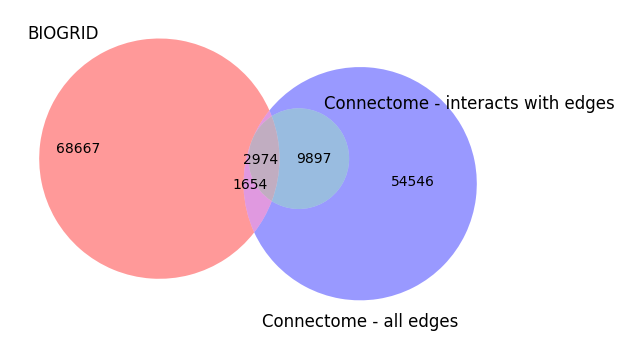

In [5]:
# !pip install matplotlib_venn
# # Getting BioGRID
# !wget https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-4.4.237/BIOGRID-ALL-4.4.237.tab.zip
# !unzip BIOGRID-ALL-4.4.237.tab.zip
# !rm BIOGRID-ALL-4.4.237.tab.zip


import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3



df = pd.read_parquet('KG_versions/KG_resolved_types_entities_relationships_fixed_gene_identifier.parquet')

# filter df to extract AGI to AGI triples
df_filtered = df[(df['source AGI'].notna()) & (df['target AGI'].notna())]




import pandas as pd
import csv
import re

file_path = 'BIOGRID-ALL-4.4.237.tab.txt'

# 1) Find the line number of the real header
with open(file_path, 'r') as f:
    for i, line in enumerate(f):
        if line.startswith('INTERACTOR_A'):
            header_row = i
            break

# 2) Read with the Python engine, skipping everything before the header
biogrid_df = pd.read_csv(
    file_path,
    sep='\t',
    skiprows=header_row,    # skip that many lines so the header becomes row 0
    engine='python',        # more tolerant of uneven rows
    quoting=csv.QUOTE_NONE, # don’t try to interpret quotes
    dtype=str,              # preserve all columns as string
    na_values=['-']         # treat lone '-' as NaN
)


agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)

biogrid_df["AGI_A"] = biogrid_df['INTERACTOR_A'].str.extract(agi_pattern)
biogrid_df["AGI_B"] = biogrid_df['INTERACTOR_B'].str.extract(agi_pattern)

biogrid_df = biogrid_df[biogrid_df['AGI_A'].notna() & biogrid_df['AGI_B'].notna()]

# For BioGRID
biogrid_df['AGI_pair_str'] = (
    biogrid_df[['AGI_A', 'AGI_B']]
    .apply(lambda row: " ".join(sorted(row)), axis=1)
    .str.lower()
)

pairs_biogrid_str = biogrid_df["AGI_pair_str"].tolist()

# For the full connectome
df_filtered['AGI_pair_str'] = (
    df_filtered[['source AGI', 'target AGI']]
    .apply(lambda row: " ".join(sorted(row)), axis=1)
    .str.lower()
)

pairs_connectome_str = df_filtered["AGI_pair_str"].tolist()

# filtered “interacts with” subset
interaction_edges = [
    'interacts with', 'interacted with', 'interact with', 'can interact with',
    'bind to', 'binds to', 'heterodimerize with', 'heterodimerizes with',
    'physically interacts with', 'interaction with', 'homodimerize with',
    'homodimerizes with', 'forms a complex with', 'forms complex with',
    'binds', 'could interact with', 'hetero-interacts with',
    'forms heteromerization with', 'form complexes with',
    'form homodimers with', 'complexed with',
]

df_interacts_connectome = df_filtered[df_filtered['relationship resolved'].isin(interaction_edges)].copy()

pairs_interacts_connectome_str = df_interacts_connectome["AGI_pair_str"].to_list()


# Create the Venn diagram
venn = venn3([set(pairs_biogrid_str), set(pairs_interacts_connectome_str), set(pairs_connectome_str)], set_labels=('BIOGRID', 'Connectome - interacts with edges', 'Connectome - all edges'))

plt.savefig('figures/fig_4_biogrid_venn.pdf')

# Display the diagram
plt.show()

### Counting edges and evidence types

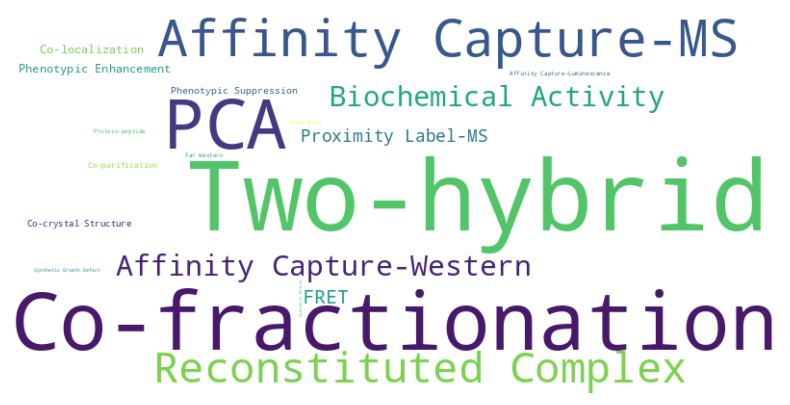

In [6]:

from collections import Counter
from wordcloud import WordCloud
biogrid_evidences = biogrid_df['EXPERIMENTAL_SYSTEM'].tolist()
# Count the occurrences of each string
counts = Counter(biogrid_evidences)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.savefig('figures/fig_4_biogrid_wordcloud.pdf')

plt.show()

### Edges shared between BIOGRID and Connectome that are not 'interacts with'

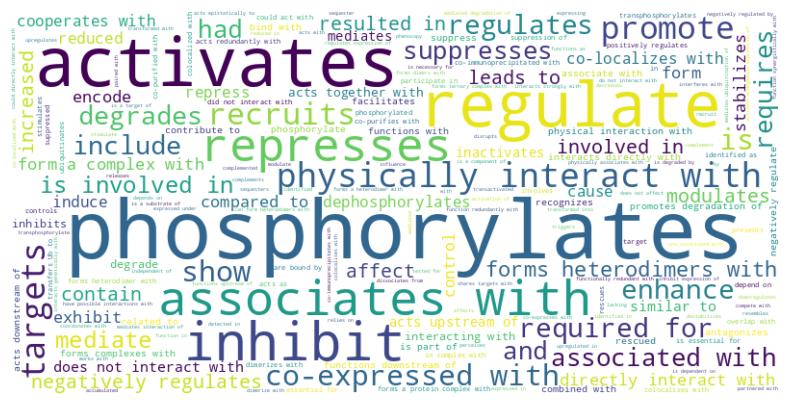

In [7]:

these_edges = set(pairs_biogrid_str) & set(pairs_interacts_connectome_str) & set(pairs_connectome_str)

df_union = df_filtered[df_filtered['AGI_pair_str'].isin(these_edges)]
df_union = df_union[~df_union['relationship resolved'].isin(interaction_edges)]
edge_types = df_union['relationship resolved'].tolist()

counts = Counter(edge_types)
# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)

# Display the word
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.savefig('figures/fig_4_biogrid_wordcloud_relationships.pdf')


plt.show()

## Comparing to AGRIS & Ecker

In [ ]:
!wget https://agris-knowledgebase.org/Downloads/AtRegNet.zip
!wget https://agris-knowledgebase.org/Downloads/AtTFDB.zip

!unzip AtRegNet.zip
!unzip AtTFDB.zip

In [ ]:
!pip install upsetplot

import pandas as pd
import re
# Read the CSV file into a DataFrame
#AtRegNet = pd.read_csv('AtRegNet.csv', index_col=False)
rows = []
with open('AtRegNet.csv', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        parts = line.strip().split(',')
        if len(parts) >= 8:
            # strip all parts
            parts = [part.strip() for part in parts]
            rows.append(parts[:8])
        else:
            print(f"Skipping line {i}: only {len(parts)} columns")

# Create DataFrame from the first 7 columns
columns = ['TFName', 'TFLocus', 'TFFamily', 'TargetName', 'TargetLocus', 'IsTF', 'TargetType', 'Confirmation']
AtRegNet = pd.DataFrame(rows, columns=columns)

AtRegNet_confirmed = AtRegNet[AtRegNet['Confirmation'].str.lower()=='confirmed'].copy()

agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)

AtRegNet_confirmed["AGI_A"] = AtRegNet_confirmed['TFLocus'].str.extract(agi_pattern)
AtRegNet_confirmed["AGI_B"] = AtRegNet_confirmed['TargetLocus'].str.extract(agi_pattern)

AtRegNet_confirmed = AtRegNet_confirmed[AtRegNet_confirmed['AGI_A'].notna() & AtRegNet_confirmed['AGI_B'].notna()]


AtRegNet_confirmed["AGI_pair_str"] = (
    AtRegNet_confirmed[['AGI_A', 'AGI_B']]
    .apply(lambda row: " ".join(row), axis=1)
    .str.lower()
)

df_filtered["AGI_pair_str_not_sorted"] = (
    df_filtered[['source AGI', 'target AGI']]
    .apply(lambda row: " ".join(row), axis=1)
    .str.lower()
)

ara_tf_df = pd.read_csv('families_data.tbl', sep='\t', header=None)
tf_set = set(ara_tf_df[1].str.lower())

connectome_tf = df_filtered[df_filtered["source AGI"].str.lower().isin(tf_set)]# | df_filtered["target AGI"].str.lower().isin(tf_set)]


#AtRegNet_tf = AtRegNet_confirmed[AtRegNet_confirmed['TFLocus'].str.lower().isin(tf_set)]


#in df_filtered, calculate two new columns:
#source is TF: check if source AGI is in ara_tfs
df_filtered['source is TF'] = df_filtered['source AGI'].str.lower().isin(tf_set)
#target is TF: check if target AGI is in ara_tfs
df_filtered['target is TF'] = df_filtered['target AGI'].str.lower().isin(tf_set)

#set false to 0 and true to 1
df_filtered['source is TF'] = df_filtered['source is TF'].astype(int)
df_filtered['target is TF'] = df_filtered['target is TF'].astype(int)

df_filtered.copy().drop(columns=['AGI_pair_str_not_sorted','AGI_pair_str']).to_csv("KG_versions/AGI_to_AGI_connections_PlantConnectome.csv")

Skipping line 15988: only 2 columns
Skipping line 15990: only 2 columns
Skipping line 16068: only 2 columns
Skipping line 16098: only 2 columns
Skipping line 16110: only 1 columns
Skipping line 16111: only 2 columns
Skipping line 16123: only 2 columns
Skipping line 16149: only 2 columns
Skipping line 16151: only 2 columns
Skipping line 16154: only 2 columns
Skipping line 16159: only 2 columns
Skipping line 16434: only 2 columns
Skipping line 16436: only 2 columns
Skipping line 16514: only 2 columns
Skipping line 16544: only 2 columns
Skipping line 16556: only 1 columns
Skipping line 16557: only 2 columns
Skipping line 16569: only 2 columns
Skipping line 16595: only 2 columns
Skipping line 16597: only 2 columns
Skipping line 16600: only 2 columns
Skipping line 16605: only 2 columns


/tmp/ipykernel_1286040/3520241660.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["AGI_pair_str_not_sorted"] = (
/tmp/ipykernel_1286040/3520241660.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['source is TF'] = df_filtered['source AGI'].str.lower().isin(tf_set)
/tmp/ipykernel_1286040/3520241660.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

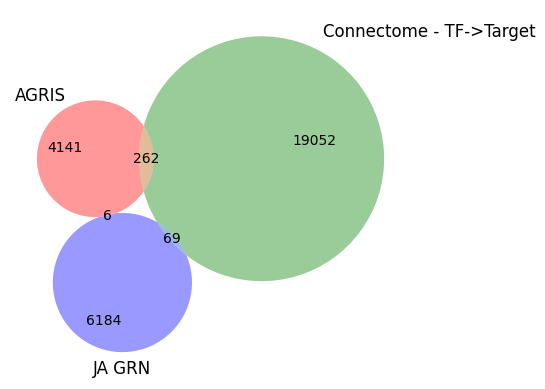

In [42]:

import re


with open('annotation/alias_to_stringDict.json', 'r') as f:
    aliasDict = json.load(f)
agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)
#load ecker dataset
ecker_df = pd.read_csv('annotation/32694625_ecker.txt', sep=' ', header=None, skiprows=1)

ecker_df.columns = ['source', 'relationship', 'target']


#map source column to aliasDict
ecker_df["source alias"] = ecker_df['source'].str.lower().map(aliasDict).fillna(ecker_df['source'].str.extract(agi_pattern)[0])
ecker_df["target alias"] = ecker_df['target'].str.lower().map(aliasDict).fillna(ecker_df['target'].str.extract(agi_pattern)[0])

ecker_df["source AGI"] = ecker_df['source alias'].str.extract(agi_pattern)[0]
ecker_df["target AGI"] = ecker_df['target alias'].str.extract(agi_pattern)[0]

ecker_df = ecker_df[ecker_df['source AGI'].notna() & ecker_df['target AGI'].notna()]

ecker_df["AGI_pair_str"] = (
    ecker_df[['source AGI', 'target AGI']]
    .apply(lambda row: " ".join(row), axis=1)
    .str.lower()
)
ecker_df = ecker_df[ecker_df["source AGI"].str.lower().isin(tf_set)]
agris_edges_confirmed = set(AtRegNet_confirmed["AGI_pair_str"].tolist())
pairs_connectome = set(connectome_tf["AGI_pair_str_not_sorted"].tolist())
pairs_ecker = set(ecker_df["AGI_pair_str"].tolist())


venn = venn3([set(agris_edges_confirmed), set(pairs_connectome), set(pairs_ecker)], set_labels=('AGRIS', 'Connectome - TF->Target', 'JA GRN'))

plt.savefig('figures/fig_4_venn_agris_connectome_ecker.pdf')

# Display the diagram
plt.show()






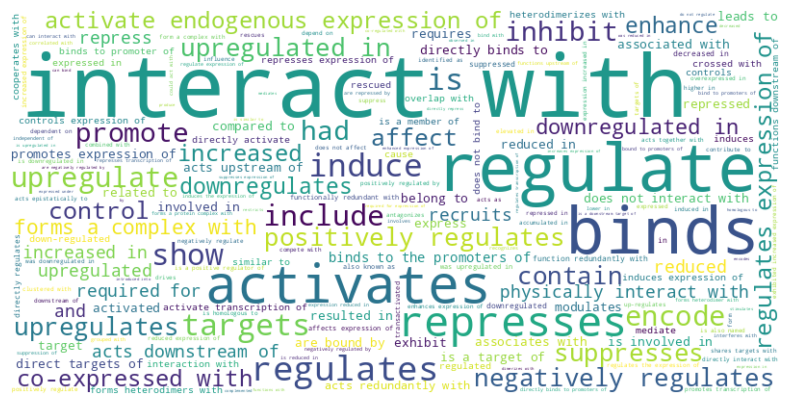

In [43]:

connectome_only = set(pairs_connectome) - (set(agris_edges_confirmed) | set(pairs_ecker))


edge_types_tf_connectome_only = []

edge_types_tf_connectome_only = df_filtered[df_filtered['AGI_pair_str_not_sorted'].isin(connectome_only)]['relationship resolved'].tolist()

# Count the occurrences of each string
counts = Counter(edge_types_tf_connectome_only)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)

# Display the word
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.savefig('figures/fig_4_wordcloud_agris_connectome_ecker.pdf')

plt.show()

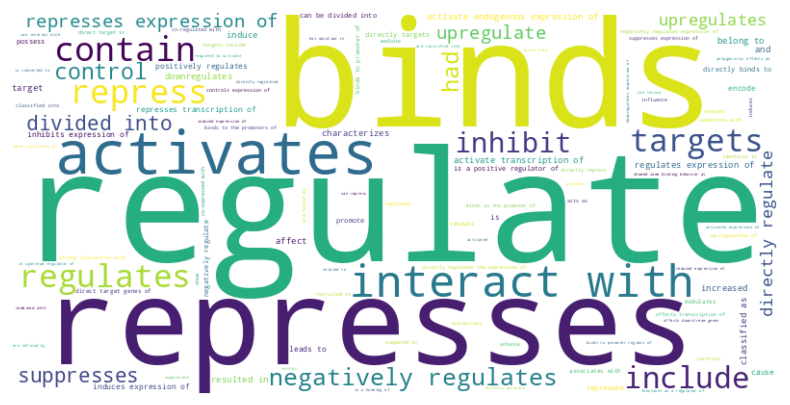

In [44]:
connectome_agris = set(pairs_connectome)&set(agris_edges_confirmed)


edge_types_tf = df_filtered[df_filtered['AGI_pair_str_not_sorted'].isin(connectome_agris)]['relationship resolved'].tolist()

# Count the occurrences of each string
counts = Counter(edge_types_tf)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)

# Display the word
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.savefig('figures/fig_4_wordcloud_agris_connectome_ecker_relationships.pdf')

plt.show()

## String DB comparison

In [ ]:
!wget https://stringdb-downloads.org/download/protein.links.detailed.v12.0/3702.protein.links.detailed.v12.0.txt.gz
!gunzip 3702.protein.links.detailed.v12.0.txt.gz
!wget https://stringdb-downloads.org/download/protein.aliases.v12.0/3702.protein.aliases.v12.0.txt.gz
!gunzip 3702.protein.aliases.v12.0.txt.gz

12557494


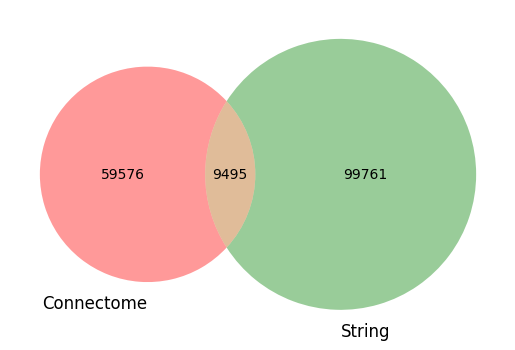

In [45]:
from matplotlib_venn import venn2
import re

# load 3702.protein.links.detailed.v12.0.txtm which is whitespace separated
string_df = pd.read_csv('3702.protein.links.detailed.v12.0.txt', sep=' ')
print(len(string_df))
string_df = string_df[string_df['textmining']>=700]



# load 3702.protein.aliases.v12.0.txt, which is tab separated
string_alias_df = pd.read_csv('3702.protein.aliases.v12.0.txt', sep='\t')
string_alias_df.head()
agi_pattern = re.compile(r'(AT[1-5CM]G\d{5})', re.IGNORECASE)
string_alias_df["AGI"] = string_alias_df['alias'].str.lower().str.extract(agi_pattern)[0]
string_alias_df = string_alias_df[string_alias_df['AGI'].notna()]


#remove duplicates of #string_protein_id and AGI.lower()
string_alias_df = string_alias_df.drop_duplicates(subset=['AGI'])
string_alias_df = string_alias_df.drop_duplicates(subset=['#string_protein_id'])
string_alias_df = string_alias_df.set_index('#string_protein_id')

#map protein1 and protein2 in string_df to AGI
string_df['protein1_AGI'] = string_df['protein1'].map(string_alias_df['AGI'])
string_df['protein2_AGI'] = string_df['protein2'].map(string_alias_df['AGI'])

string_df = string_df[string_df['protein1_AGI'].notna() & string_df['protein2_AGI'].notna()]



string_df['string_agi_str'] = (
    string_df[['protein1_AGI', 'protein2_AGI']]
    .apply(lambda row: " ".join(sorted(row)), axis=1)
    .str.lower()
)

string_interactions = set(string_df["string_agi_str"])

connectome_only_ppis = set(df_filtered["AGI_pair_str"])


#plot the 2 way venn diagram of string_interactions and connectome_only_ppis
venn2([connectome_only_ppis, string_interactions], set_labels=('Connectome', 'String'))
plt.savefig('figures/fig_4_venn_connectome_string.pdf')
plt.show()


## Evaluating accuracy of edges

Getting the knowledge graph and text chunks

In [ ]:
# prompt: mount drive
import pandas as pd
from google.colab import drive
import os, json

drive.mount('/content/drive')

!pip install matplotlib squarify
!pip install wordcloud
!pip install networkx
!pip install biopython
!pip install openai
#!python -m spacy download en_core_web_md

import nltk
nltk.download('punkt')
nltk.download('wordnet')
#df = pd.read_csv('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/plantconnectome_knowledgegraph_types_mads.csv') #old version befor relationship fix
#df = pd.read_csv('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/plantconnectome_knowledgegraph_types_relationshipsFixed_mads.csv')
df = pd.read_parquet('/home/mads/connectome/colab_figures/KG_versions/KG_resolved_types_entities_relationships_fixed_gene_identifier.parquet')



# Initialize empty dictionary to store papers
papers = {}

# Function to read each JSONL file and add contents to 'papers' dictionary
def read_jsonl_file(file_name):
    with open(file_name, 'r') as f:
        for line in f:
            # Load each line as a JSON object
            data = json.loads(line.strip())

            # Assuming each JSON object has a unique key such as 'id' or 'paper_id'
            # Adjust based on the actual structure of your JSON data
            paper_id = data.get('custom_id')  # Change 'id' to the appropriate key in your JSON structure

            # Add the paper to the dictionary
            papers[paper_id] = data['body']['messages'][-1]['content']

for i in os.listdir('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/inputs'):
    print(i)
    read_jsonl_file('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/inputs/'+i)

# 'papers' now contains all the loaded data from the files
print(f"Total papers loaded: {len(papers)}")

#### PPI

In [ ]:
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3



#Importing biogrid
pattern = r"at[1-5CM]g\d{5}"
ara_biogrid = open('BIOGRID-ALL-4.4.237.tab.txt','r').readlines()[1:]

pairs_biogrid = {}

biogrid_evidences = []
for i in ara_biogrid:
    splitta = i.lower().split('\t')
    # Find all matches
    if len(splitta)>1:
        genes = re.findall(pattern, splitta[0]+splitta[1])

        if len(genes)==2: #if a pair is found, grab the pair and also experimental evidence
            lista = sorted([genes[0].lower(), genes[1].lower()])
            if lista[0] not in pairs_biogrid:
                pairs_biogrid[tuple(lista)] = [[splitta[6]]]
            else:
                pairs_biogrid[tuple(lista)] += [[splitta[6]]]
            biogrid_evidences += [splitta[6]]


##Importing connectome
pairs_interacts_with_connectome = {}

ara_connectome = open('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/knowledge_graph_agi_multithread.txt','r').readlines()
interaction_edges = ['interacts with', 'interacted with', 'interact with', 'can interact with', 'bind to', 'binds to',
                     'heterodimerize with', 'heterodimerizes with', 'physically interacts with', 'interaction with',
                     'homodimerize with', 'homodimerizes with', 'forms a complex with', 'forms complex with',
                     'binds', 'could interact with', 'hetero-interacts with', 'forms heteromerization with', 'form complexes with',
                     'form homodimers with', 'complexed with',

                     ]
for i in ara_connectome:
    splitta = i.rstrip().split('\t')

    if splitta!=['']:
        lista = sorted([splitta[-1].lower(), splitta[-2].lower()])
        if splitta[2] in interaction_edges:
            if lista[0] not in pairs_interacts_with_connectome:
                pairs_interacts_with_connectome[tuple(lista)] = [[' '.join([splitta[0], splitta[2], splitta[3]]), splitta[7]]]
            else:
                pairs_interacts_with_connectome[tuple(lista)] += [[' '.join([splitta[0], splitta[2], splitta[3]]), splitta[7]]]

connectome_only_ppis = set(pairs_interacts_with_connectome) - set(pairs_biogrid)


##gettting connectome-specific edges and abstracts for openAI analysis
edges_analysis = list(connectome_only_ppis)[:150]

edge2chunk = {}

for i in edges_analysis:
    edge2chunk[i] = [pairs_interacts_with_connectome[i][0][0], papers[pairs_interacts_with_connectome[i][0][1]], pairs_interacts_with_connectome[i][0][1].split(': ')[-1]]


In [ ]:
from openai import OpenAI

# Specify your API key
api_key = "ENTER KEY"

# Initialize OpenAI client with API key
client = OpenAI(api_key=api_key)

keys = list(edge2chunk.keys())

openai_requests = []
for i in range(20,30):
    print(i)
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": "Return the information from the text that supports the statement. Statement: (%s). Text (%s)\n\n Return the sentence exactly as it is in the text. If you cannot find the information, write: Information not found." % (edge2chunk[keys[i]][0], edge2chunk[keys[i]][1]),
            }
        ]
    )
    openai_requests.append([edge2chunk[keys[i]][2], edge2chunk[keys[i]][0], edge2chunk[keys[i]][1], completion])

save = ['source\tstatement\tchunk\tCorresponding sentence\n']
for i in openai_requests:
    save.append('\t'.join([i[0], i[1], i[2], i[3].choices[0].message.content])+'\n')


v = open('edge_testing.txt','w')
v.writelines(save)
v.close()


### Transcription factor -> target edges

In [ ]:
!wget https://agris-knowledgebase.org/Downloads/AtRegNet.zip
!wget https://agris-knowledgebase.org/Downloads/AtTFDB.zip

!unzip AtRegNet.zip
!unzip AtTFDB.zip


In [ ]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import re


##Getting agris
agris_edges_confirmed = {}
agris_edges_unconfirmed = {}
for i in open('AtRegNet.csv','r').readlines():
    splitta = i.lower().split(',')
    if len(splitta)>6:
        if 'confirmed' == splitta[7]:
            agris_edges_confirmed[tuple([splitta[1], splitta[4]])] = splitta[9]
        else:
            agris_edges_unconfirmed[tuple([splitta[1], splitta[4]])] = splitta[9]


ara_tfs = []
for i in open('families_data.tbl','r').readlines()[1:]:
    ara_tfs += [i.split('\t')[1].lower()]

'''
regulation_edges = ['interacts with', 'interacted with', 'interact with', 'can interact with', 'bind to', 'binds to',
                     'heterodimerize with', 'heterodimerizes with', 'physically interacts with', 'interaction with',
                     'homodimerize with', 'homodimerizes with', 'forms a complex with', 'forms complex with',
                     'binds', 'could interact with', 'hetero-interacts with'
                     ]
'''

##Getting connectome
pairs_tf_connectome = {}
ara_connectome = open('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/knowledge_graph_agi_multithread.txt','r').readlines()
for i in ara_connectome:
    splitta = i.rstrip().split('\t')
    if splitta!=['']:
        if splitta[-2] in ara_tfs and splitta[2]=='regulate': # if source is transcription factor
            if tuple([splitta[-2].lower(), splitta[-1].lower()]) not in pairs_tf_connectome:
                pairs_tf_connectome[tuple([splitta[-2].lower(), splitta[-1].lower()])] = [[' '.join([splitta[0], splitta[2], splitta[3]]), splitta[7]]]
            else:
                pairs_tf_connectome[tuple([splitta[-2].lower(), splitta[-1].lower()])] += [[' '.join([splitta[0], splitta[2], splitta[3]]), splitta[7]]]


connectome_only_tfs = set(pairs_tf_connectome) - set(agris_edges_confirmed)


##gettting connectome-specific edges and abstracts for openAI analysis
edges_analysis = list(connectome_only_tfs)[80:100]

edge2chunk = {}

for i in edges_analysis:
    edge2chunk[i] = [pairs_tf_connectome[i][0][0], papers[pairs_tf_connectome[i][0][1]], pairs_tf_connectome[i][0][1].split(': ')[-1]]


In [ ]:
from openai import OpenAI

# Specify your API key
api_key = "ENTER KEYA"

# Initialize OpenAI client with API key
client = OpenAI(api_key=api_key)

keys = list(edge2chunk.keys())

openai_requests = []
for i in range(20):
    print(i)
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": "Return the information from the text that supports the statement. Statement: (%s). Text (%s)\n\n Return the sentence exactly as it is in the text. If you cannot find the information, write: Information not found." % (edge2chunk[keys[i]][0], edge2chunk[keys[i]][1]),
            }
        ]
    )
    openai_requests.append([edge2chunk[keys[i]][2], edge2chunk[keys[i]][0], edge2chunk[keys[i]][1], completion])

save = ['source\tstatement\tchunk\tCorresponding sentence\n']
for i in openai_requests:
    save.append('\t'.join([i[0], i[1], i[2], i[3].choices[0].message.content])+'\n')


v = open('edge_tf_testing.txt','w')
v.writelines(save)
v.close()


### 150 edges before and after Oct 2023

In [ ]:
import os, json

######Getting text of a chunk
# Initialize empty dictionary to store papers
chunk_2_text = {}

# Function to read each JSONL file and add contents to 'papers' dictionary
def read_jsonl_file(file_name):
    with open(file_name, 'r') as f:
        for line in f:
            # Load each line as a JSON object
            data = json.loads(line.strip())

            # Assuming each JSON object has a unique key such as 'id' or 'paper_id'
            # Adjust based on the actual structure of your JSON data
            paper_id = data.get('custom_id')  # Change 'id' to the appropriate key in your JSON structure

            # Add the paper to the dictionary
            chunk_2_text[paper_id] = data['body']['messages'][-1]['content']

for i in os.listdir('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/inputs'):
    read_jsonl_file('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/inputs/'+i)

# 'papers' now contains all the loaded data from the files
print(f"Total papers loaded: {len(papers)}")


######Getting publication year
papers = open('/content/drive/MyDrive/shanchun/Connectome figures/KG colab/analyzed_papers.txt','r').readlines()[1:]

year2024, before = [],[]
pmid2year = {}
for i in papers:
    splitta = i.rstrip().split('\t')
    pmid2year[splitta[-2]] = splitta[-3]
    if splitta[-3]=='2024':
        year2024.append(int(splitta[-2]))
    else:
        before.append(int(splitta[-2]))


######Getting dataframe that grabs 150 2024 and older publications.
# Assuming df['pmid'] is either string or int, convert them if necessary for matching
df['pmid'] = df['pmid'].astype(str)

# Add the 'year' column to df using pmid2year dictionary
df['year'] = df['pmid'].map(pmid2year)

df['chunk_text'] = df['p_source'].map(chunk_2_text)

# Filter the rows based on the year being 2024 or before 2024
df_2024 = df[df['year'] == '2024']
df_before = df[df['year'] != '2024']

# Randomly select 150 rows from each subset
df_year2024_sample = df_2024.sample(n=200, random_state=42)
df_before2024_sample = df_before.sample(n=200, random_state=42)

# Combine the two samples
df_combined = pd.concat([df_year2024_sample, df_before2024_sample])


edge2chunk = []
for index, row in df_combined.iterrows():
    statement = row['source resolved']+' '+row['relationship_updated']+' '+row['target resolved']
    edge2chunk.append([statement, row['chunk_text']])

df_combined

In [ ]:
from openai import OpenAI

# Specify your API key
api_key = "ENTER KEY"

# Initialize OpenAI client with API key
client = OpenAI(api_key=api_key)

openai_requests = []
for i in range(len(edge2chunk)):
    print(i)
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": "Return the information from the text that supports the statement. Statement: (%s). Text (%s)\n\n Return the sentence exactly as it is in the text. If you cannot find the information, write: Information not found." % (edge2chunk[i][0], edge2chunk[i][1]),
            }
        ]
    )
    openai_requests.append(completion.choices[0].message.content)


df_combined['Corresponding sentence'] = openai_requests
output_file_path = 'df_combined_output.txt'
df_combined.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
output_file_path = '/content/drive/MyDrive/shanchun/Connectome figures/KG colab/2024_vs_before_comparison.txt'
df_combined.to_csv(output_file_path, sep='\t', index=False)